In [14]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
DATA_PATH = './data/'
TRAIN_PATH = './data/stage1_train/'
TEST_PATH = './data/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 1
random.seed = seed
np.random.seed = seed


In [6]:
# Get train and test IDs
# next os.walk(path) returns a tuple (top DIR, folder DIRs, file names)
train_ids = next(os.walk(TRAIN_PATH))[1]  
test_ids = next(os.walk(TEST_PATH))[1]

Get the data
1. Let's first import all the images and associated masks. I downsample both the training and test images to keep things light and manageable
2. but we need to keep a record of the original sizes of the test images to upsample our predicted masks and create correct run-length encodings later on. There are definitely better ways to handle this, but it works fine for now!

In [26]:
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
#
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


  0%|          | 0/670 [00:00<?, ?it/s]

  0%|          | 1/670 [00:00<01:11,  9.38it/s]

  0%|          | 3/670 [00:00<00:46, 14.35it/s]

  1%|          | 5/670 [00:00<00:43, 15.29it/s]

  1%|▏         | 9/670 [00:00<00:32, 20.57it/s]

  2%|▏         | 11/670 [00:00<00:32, 20.01it/s]

  2%|▏         | 14/670 [00:00<00:30, 21.50it/s]

  3%|▎         | 19/670 [00:00<00:27, 23.69it/s]

  3%|▎         | 22/670 [00:01<00:35, 18.20it/s]

  4%|▎         | 24/670 [00:01<00:43, 14.83it/s]

  4%|▍         | 26/670 [00:01<00:43, 14.94it/s]

  4%|▍         | 28/670 [00:01<00:44, 14.37it/s]

  5%|▍         | 31/670 [00:02<00:49, 13.02it/s]

  5%|▍         | 33/670 [00:02<00:51, 12.32it/s]

  5%|▌         | 35/670 [00:03<00:54, 11.59it/s]

  6%|▌         | 38/670 [00:03<00:52, 12.07it/s]

  6%|▌         | 40/670 [00:03<00:53, 11.82it/s]

  6%|▋         | 42/670 [00:03<00:55, 11.35it/s]

  7%|▋         | 44/670 [00:03<00:54, 11.54it/s]

  7%|▋         | 48/670 [00:03<00:50, 12.24it/s]

  8%|▊         | 51/670 [00:04<00:48, 12.67it/s]

  8%|▊         | 55/670 [00:04<00:50, 12.13it/s]

  9%|▉         | 59/670 [00:04<00:48, 12.49it/s]

  9%|▉         | 61/670 [00:05<00:52, 11.52it/s]

  9%|▉         | 63/670 [00:05<00:53, 11.42it/s]

 10%|█         | 67/670 [00:05<00:50, 11.91it/s]

 10%|█         | 69/670 [00:05<00:49, 12.02it/s]

 11%|█         | 71/670 [00:06<00:57, 10.38it/s]

 11%|█         | 73/670 [00:07<00:57, 10.31it/s]

 11%|█▏        | 76/670 [00:07<00:56, 10.52it/s]

 12%|█▏        | 78/670 [00:07<00:58, 10.13it/s]

 12%|█▏        | 82/670 [00:07<00:56, 10.48it/s]

 13%|█▎        | 86/670 [00:07<00:54, 10.77it/s]

 13%|█▎        | 89/670 [00:08<00:53, 10.77it/s]

 14%|█▍        | 93/670 [00:08<00:51, 11.10it/s]

 14%|█▍        | 96/670 [00:08<00:50, 11.29it/s]

 15%|█▍        | 100/670 [00:08<00:49, 11.59it/s]

 15%|█▌        | 103/670 [00:08<00:48, 11.76it/s]

 16%|█▌        | 108/670 [00:08<00:46, 12.15it/s]

 17%|█▋        | 111/670 [00:09<00:45, 12.31it/s]

 17%|█▋        | 114/670 [00:09<00:47, 11.63it/s]

 17%|█▋        | 117/670 [00:10<00:47, 11.53it/s]

 18%|█▊        | 119/670 [00:10<00:48, 11.38it/s]

 18%|█▊        | 121/670 [00:10<00:48, 11.35it/s]

 18%|█▊        | 123/670 [00:10<00:47, 11.42it/s]

 19%|█▉        | 126/670 [00:10<00:46, 11.58it/s]

 19%|█▉        | 129/670 [00:10<00:46, 11.75it/s]

 20%|█▉        | 132/670 [00:11<00:45, 11.89it/s]

 20%|██        | 136/670 [00:11<00:44, 12.09it/s]

 21%|██        | 140/670 [00:11<00:43, 12.13it/s]

 21%|██▏       | 144/670 [00:11<00:42, 12.31it/s]

 22%|██▏       | 147/670 [00:11<00:42, 12.40it/s]

 23%|██▎       | 151/670 [00:11<00:41, 12.63it/s]

 23%|██▎       | 157/670 [00:12<00:39, 13.00it/s]

 24%|██▍       | 161/670 [00:12<00:40, 12.49it/s]

 25%|██▍       | 165/670 [00:13<00:39, 12.66it/s]

 25%|██▌       | 169/670 [00:13<00:38, 12.86it/s]

 26%|██▌       | 173/670 [00:13<00:38, 13.00it/s]

 26%|██▋       | 176/670 [00:13<00:37, 13.09it/s]

 27%|██▋       | 180/670 [00:13<00:36, 13.26it/s]

 27%|██▋       | 183/670 [00:13<00:36, 13.29it/s]

 28%|██▊       | 186/670 [00:14<00:36, 13.09it/s]

 28%|██▊       | 190/670 [00:14<00:36, 13.25it/s]

 29%|██▉       | 193/670 [00:14<00:35, 13.31it/s]

 29%|██▉       | 196/670 [00:14<00:35, 13.42it/s]

 30%|██▉       | 199/670 [00:14<00:34, 13.48it/s]

 30%|███       | 203/670 [00:14<00:34, 13.58it/s]

 31%|███       | 206/670 [00:15<00:33, 13.67it/s]

 31%|███       | 209/670 [00:15<00:34, 13.37it/s]

 31%|███▏      | 211/670 [00:15<00:34, 13.38it/s]

 32%|███▏      | 214/670 [00:15<00:33, 13.48it/s]

 33%|███▎      | 218/670 [00:16<00:33, 13.60it/s]

 33%|███▎      | 221/670 [00:16<00:33, 13.43it/s]

 34%|███▎      | 226/670 [00:16<00:32, 13.65it/s]

 34%|███▍      | 229/670 [00:16<00:32, 13.65it/s]

 35%|███▍      | 232/670 [00:16<00:31, 13.74it/s]

 35%|███▌      | 235/670 [00:16<00:31, 13.83it/s]

 36%|███▌      | 240/670 [00:17<00:31, 13.75it/s]

 36%|███▋      | 243/670 [00:17<00:31, 13.51it/s]

 37%|███▋      | 246/670 [00:18<00:31, 13.55it/s]

 37%|███▋      | 248/670 [00:18<00:31, 13.53it/s]

 37%|███▋      | 250/670 [00:18<00:30, 13.56it/s]

 38%|███▊      | 253/670 [00:18<00:30, 13.65it/s]

 38%|███▊      | 256/670 [00:18<00:30, 13.61it/s]

 39%|███▉      | 261/670 [00:19<00:29, 13.70it/s]

 39%|███▉      | 263/670 [00:19<00:30, 13.54it/s]

 40%|███▉      | 266/670 [00:19<00:29, 13.48it/s]

 40%|████      | 268/670 [00:19<00:29, 13.47it/s]

 40%|████      | 270/670 [00:20<00:31, 12.89it/s]

 41%|████      | 273/670 [00:21<00:30, 12.97it/s]

 41%|████      | 275/670 [00:21<00:31, 12.54it/s]

 42%|████▏     | 279/670 [00:22<00:31, 12.37it/s]

 42%|████▏     | 281/670 [00:22<00:31, 12.28it/s]

 43%|████▎     | 285/670 [00:23<00:31, 12.37it/s]

 43%|████▎     | 289/670 [00:23<00:30, 12.33it/s]

 43%|████▎     | 291/670 [00:23<00:30, 12.25it/s]

 44%|████▍     | 295/670 [00:23<00:30, 12.35it/s]

 44%|████▍     | 297/670 [00:24<00:30, 12.33it/s]

 45%|████▍     | 300/670 [00:24<00:29, 12.40it/s]

 45%|████▌     | 302/670 [00:24<00:30, 12.24it/s]

 46%|████▌     | 305/670 [00:24<00:29, 12.27it/s]

 46%|████▌     | 307/670 [00:24<00:29, 12.29it/s]

 47%|████▋     | 312/670 [00:25<00:28, 12.43it/s]

 47%|████▋     | 315/670 [00:25<00:28, 12.40it/s]

 47%|████▋     | 318/670 [00:25<00:28, 12.36it/s]

 48%|████▊     | 324/670 [00:26<00:28, 12.29it/s]

 49%|████▊     | 326/670 [00:26<00:27, 12.30it/s]

 49%|████▉     | 328/670 [00:26<00:27, 12.32it/s]

 49%|████▉     | 330/670 [00:27<00:28, 12.06it/s]

 50%|████▉     | 332/670 [00:27<00:28, 12.06it/s]

 50%|█████     | 337/670 [00:27<00:27, 12.17it/s]

 51%|█████     | 341/670 [00:27<00:26, 12.23it/s]

 51%|█████▏    | 344/670 [00:27<00:26, 12.29it/s]

 52%|█████▏    | 347/670 [00:28<00:26, 12.32it/s]

 52%|█████▏    | 349/670 [00:28<00:26, 12.33it/s]

 52%|█████▏    | 351/670 [00:28<00:26, 12.18it/s]

 53%|█████▎    | 353/670 [00:28<00:26, 12.18it/s]

 53%|█████▎    | 356/670 [00:29<00:25, 12.16it/s]

 54%|█████▎    | 360/670 [00:29<00:25, 12.26it/s]

 54%|█████▍    | 364/670 [00:29<00:24, 12.35it/s]

 55%|█████▍    | 368/670 [00:29<00:24, 12.42it/s]

 55%|█████▌    | 371/670 [00:29<00:24, 12.44it/s]

 56%|█████▌    | 374/670 [00:30<00:24, 12.24it/s]

 56%|█████▋    | 377/670 [00:30<00:23, 12.29it/s]

 57%|█████▋    | 380/670 [00:30<00:23, 12.34it/s]

 57%|█████▋    | 384/670 [00:31<00:23, 12.33it/s]

 58%|█████▊    | 387/670 [00:31<00:22, 12.37it/s]

 58%|█████▊    | 391/670 [00:31<00:22, 12.45it/s]

 59%|█████▉    | 394/670 [00:31<00:22, 12.50it/s]

 60%|█████▉    | 399/670 [00:31<00:21, 12.59it/s]

 60%|██████    | 402/670 [00:31<00:21, 12.61it/s]

 61%|██████    | 406/670 [00:32<00:20, 12.68it/s]

 61%|██████    | 410/670 [00:32<00:20, 12.73it/s]

 62%|██████▏   | 413/670 [00:32<00:20, 12.71it/s]

 62%|██████▏   | 416/670 [00:33<00:20, 12.29it/s]

 62%|██████▏   | 418/670 [00:34<00:20, 12.25it/s]

 63%|██████▎   | 421/670 [00:34<00:20, 12.30it/s]

 63%|██████▎   | 423/670 [00:34<00:20, 12.15it/s]

 64%|██████▎   | 427/670 [00:34<00:19, 12.22it/s]

 64%|██████▍   | 432/670 [00:35<00:19, 12.23it/s]

 65%|██████▍   | 434/670 [00:35<00:19, 12.25it/s]

 65%|██████▌   | 436/670 [00:35<00:19, 12.13it/s]

 66%|██████▌   | 441/670 [00:36<00:18, 12.23it/s]

 66%|██████▋   | 444/670 [00:36<00:18, 12.21it/s]

 67%|██████▋   | 446/670 [00:36<00:18, 12.21it/s]

 67%|██████▋   | 449/670 [00:36<00:18, 12.18it/s]

 67%|██████▋   | 451/670 [00:36<00:17, 12.19it/s]

 68%|██████▊   | 454/670 [00:37<00:17, 12.24it/s]

 68%|██████▊   | 458/670 [00:37<00:17, 12.30it/s]

 69%|██████▉   | 461/670 [00:37<00:16, 12.34it/s]

 69%|██████▉   | 464/670 [00:37<00:16, 12.37it/s]

 70%|██████▉   | 468/670 [00:37<00:16, 12.37it/s]

 70%|███████   | 470/670 [00:38<00:16, 12.32it/s]

 70%|███████   | 472/670 [00:38<00:16, 12.29it/s]

 71%|███████   | 475/670 [00:38<00:16, 12.18it/s]

 71%|███████▏  | 479/670 [00:39<00:15, 12.25it/s]

 72%|███████▏  | 481/670 [00:39<00:15, 12.25it/s]

 72%|███████▏  | 483/670 [00:39<00:15, 12.26it/s]

 73%|███████▎  | 486/670 [00:39<00:14, 12.31it/s]

 73%|███████▎  | 488/670 [00:39<00:14, 12.23it/s]

 73%|███████▎  | 490/670 [00:40<00:14, 12.18it/s]

 74%|███████▎  | 493/670 [00:40<00:14, 12.22it/s]

 74%|███████▍  | 497/670 [00:40<00:14, 12.28it/s]

 75%|███████▍  | 500/670 [00:40<00:13, 12.30it/s]

 75%|███████▌  | 503/670 [00:40<00:13, 12.33it/s]

 76%|███████▌  | 508/670 [00:40<00:13, 12.42it/s]

 77%|███████▋  | 513/670 [00:41<00:12, 12.50it/s]

 77%|███████▋  | 517/670 [00:41<00:12, 12.55it/s]

 78%|███████▊  | 521/670 [00:41<00:11, 12.59it/s]

 78%|███████▊  | 524/670 [00:41<00:11, 12.62it/s]

 79%|███████▊  | 527/670 [00:41<00:11, 12.61it/s]

 79%|███████▉  | 531/670 [00:41<00:10, 12.67it/s]

 80%|███████▉  | 534/670 [00:42<00:10, 12.70it/s]

 80%|████████  | 538/670 [00:42<00:10, 12.75it/s]

 81%|████████  | 541/670 [00:42<00:10, 12.63it/s]

 81%|████████▏ | 545/670 [00:42<00:09, 12.69it/s]

 82%|████████▏ | 549/670 [00:43<00:09, 12.68it/s]

 82%|████████▏ | 552/670 [00:43<00:09, 12.70it/s]

 83%|████████▎ | 556/670 [00:43<00:08, 12.76it/s]

 83%|████████▎ | 559/670 [00:43<00:08, 12.79it/s]

 84%|████████▍ | 562/670 [00:43<00:08, 12.78it/s]

 84%|████████▍ | 564/670 [00:44<00:08, 12.74it/s]

 85%|████████▍ | 569/670 [00:44<00:07, 12.76it/s]

 85%|████████▌ | 572/670 [00:44<00:07, 12.78it/s]

 86%|████████▌ | 574/670 [00:44<00:07, 12.78it/s]

 86%|████████▌ | 577/670 [00:45<00:07, 12.80it/s]

 86%|████████▋ | 579/670 [00:45<00:07, 12.79it/s]

 87%|████████▋ | 582/670 [00:45<00:06, 12.82it/s]

 87%|████████▋ | 585/670 [00:45<00:06, 12.84it/s]

 88%|████████▊ | 589/670 [00:45<00:06, 12.90it/s]

 88%|████████▊ | 592/670 [00:45<00:06, 12.91it/s]

 89%|████████▉ | 595/670 [00:45<00:05, 12.94it/s]

 89%|████████▉ | 598/670 [00:47<00:05, 12.72it/s]

 90%|████████▉ | 601/670 [00:47<00:05, 12.74it/s]

 90%|█████████ | 604/670 [00:47<00:05, 12.78it/s]

 91%|█████████ | 608/670 [00:47<00:04, 12.83it/s]

 91%|█████████ | 611/670 [00:47<00:04, 12.80it/s]

 92%|█████████▏| 614/670 [00:47<00:04, 12.83it/s]

 92%|█████████▏| 617/670 [00:48<00:04, 12.84it/s]

 93%|█████████▎| 622/670 [00:48<00:03, 12.91it/s]

 93%|█████████▎| 625/670 [00:48<00:03, 12.77it/s]

 94%|█████████▎| 628/670 [00:49<00:03, 12.74it/s]

 94%|█████████▍| 631/670 [00:49<00:03, 12.76it/s]

 95%|█████████▍| 634/670 [00:49<00:02, 12.75it/s]

 95%|█████████▍| 636/670 [00:49<00:02, 12.75it/s]

 95%|█████████▌| 638/670 [00:49<00:02, 12.76it/s]

 96%|█████████▌| 640/670 [00:50<00:02, 12.71it/s]

 96%|█████████▌| 644/670 [00:50<00:02, 12.76it/s]

 97%|█████████▋| 647/670 [00:50<00:01, 12.78it/s]

 97%|█████████▋| 652/670 [00:50<00:01, 12.85it/s]

 98%|█████████▊| 656/670 [00:50<00:01, 12.89it/s]

 99%|█████████▊| 660/670 [00:51<00:00, 12.92it/s]

 99%|█████████▉| 663/670 [00:51<00:00, 12.91it/s]

 99%|█████████▉| 666/670 [00:52<00:00, 12.80it/s]

100%|█████████▉| 669/670 [00:52<00:00, 12.84it/s]

100%|██████████| 670/670 [00:52<00:00, 12.84it/s]

Getting and resizing test images ... 



  0%|          | 0/65 [00:00<?, ?it/s]

 29%|██▉       | 19/65 [00:00<00:00, 164.17it/s]

 52%|█████▏    | 34/65 [00:00<00:00, 153.98it/s]

 71%|███████   | 46/65 [00:00<00:00, 139.07it/s]

 89%|████████▉ | 58/65 [00:00<00:00, 132.48it/s]

100%|██████████| 65/65 [00:00<00:00, 133.61it/s]

Done!


In [38]:
X_train.shape, Y_train.shape, X_test.shape

((670, 128, 128, 3), (670, 128, 128, 1), (65, 128, 128, 3))

In [39]:
np.save(DATA_PATH + 'X_train_128.npy', X_train)
np.save(DATA_PATH + 'X_test_128.npy', X_test)
np.save(DATA_PATH + 'Y_train_128.npy', Y_train)

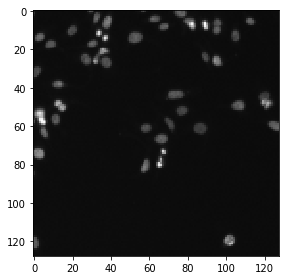

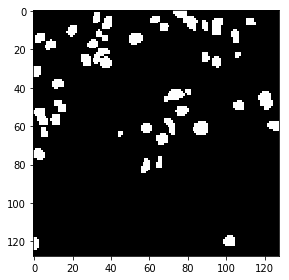

In [36]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [37]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [40]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  224         lambda_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_poolin

In [41]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=2, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=30, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/30


  8/603 [..............................] - ETA: 1:30 - loss: 0.6923 - mean_iou: 0.0000e+00

 24/603 [>.............................] - ETA: 31s - loss: 0.6913 - mean_iou: 0.2804     

 40/603 [>.............................] - ETA: 18s - loss: 0.6896 - mean_iou: 0.3371

 56/603 [=>............................] - ETA: 13s - loss: 0.6857 - mean_iou: 0.3625

 72/603 [==>...........................] - ETA: 10s - loss: 0.6808 - mean_iou: 0.3764

 88/603 [===>..........................] - ETA: 8s - loss: 0.6636 - mean_iou: 0.3858 

104/603 [====>.........................] - ETA: 7s - loss: 0.6525 - mean_iou: 0.3922

120/603 [====>.........................] - ETA: 6s - loss: 0.6405 - mean_iou: 0.3969

136/603 [=====>........................] - ETA: 5s - loss: 0.6350 - mean_iou: 0.4005

152/603 [======>.......................] - ETA: 5s - loss: 0.6289 - mean_iou: 0.4029

168/603 [=======>......................] - ETA: 4s - loss: 0.6236 - mean_iou: 0.4049

184/603 [========>.....................] - ETA: 4s - loss: 0.6183 - mean_iou: 0.4065

200/603 [========>.....................] - ETA: 3s - loss: 0.6093 - mean_iou: 0.4079

216/603 [=========>....................] - ETA: 3s - loss: 0.5994 - mean_iou: 0.4092

232/603 [==========>...................] - ETA: 3s - loss: 0.5952 - mean_iou: 0.4103

248/603 [===========>..................] - ETA: 3s - loss: 0.5885 - mean_iou: 0.4112

264/603 [============>.................] - ETA: 2s - loss: 0.5805 - mean_iou: 0.4120

280/603 [============>.................] - ETA: 2s - loss: 0.5704 - mean_iou: 0.4128

296/603 [=============>................] - ETA: 2s - loss: 0.5651 - mean_iou: 0.4135

312/603 [==============>...............] - ETA: 2s - loss: 0.5601 - mean_iou: 0.4141

328/603 [===============>..............] - ETA: 1s - loss: 0.5526 - mean_iou: 0.4147

344/603 [================>.............] - ETA: 1s - loss: 0.5450 - mean_iou: 0.4152

360/603 [================>.............] - ETA: 1s - loss: 0.5375 - mean_iou: 0.4156

376/603 [=================>............] - ETA: 1s - loss: 0.5311 - mean_iou: 0.4161

392/603 [==================>...........] - ETA: 1s - loss: 0.5310 - mean_iou: 0.4165

408/603 [===================>..........] - ETA: 1s - loss: 0.5283 - mean_iou: 0.4169

424/603 [====================>.........] - ETA: 1s - loss: 0.5234 - mean_iou: 0.4172

440/603 [====================>.........] - ETA: 1s - loss: 0.5196 - mean_iou: 0.4175

456/603 [=====================>........] - ETA: 0s - loss: 0.5165 - mean_iou: 0.4178

472/603 [======================>.......] - ETA: 0s - loss: 0.5125 - mean_iou: 0.4181

488/603 [=======================>......] - ETA: 0s - loss: 0.5111 - mean_iou: 0.4183

504/603 [========================>.....] - ETA: 0s - loss: 0.5069 - mean_iou: 0.4186

520/603 [========================>.....] - ETA: 0s - loss: 0.5036 - mean_iou: 0.4188

536/603 [=========================>....] - ETA: 0s - loss: 0.5002 - mean_iou: 0.4190

552/603 [==========================>...] - ETA: 0s - loss: 0.4977 - mean_iou: 0.4192

568/603 [===========================>..] - ETA: 0s - loss: 0.4961 - mean_iou: 0.4193

584/603 [============================>.] - ETA: 0s - loss: 0.4942 - mean_iou: 0.4195

600/603 [============================>.] - ETA: 0s - loss: 0.4915 - mean_iou: 0.4196

Epoch 00001: val_loss improved from inf to 0.40121, saving model to model-dsbowl2018-1.h5


603/603 [==============================] - 4s 7ms/step - loss: 0.4915 - mean_iou: 0.4196 - val_loss: 0.4012 - val_mean_iou: 0.4243


Epoch 2/30
  8/603 [..............................] - ETA: 2s - loss: 0.4180 - mean_iou: 0.4237

 24/603 [>.............................] - ETA: 2s - loss: 0.3761 - mean_iou: 0.4237

 40/603 [>.............................] - ETA: 2s - loss: 0.3923 - mean_iou: 0.4237

 56/603 [=>............................] - ETA: 1s - loss: 0.3711 - mean_iou: 0.4237

 72/603 [==>...........................] - ETA: 1s - loss: 0.3577 - mean_iou: 0.4238

 88/603 [===>..........................] - ETA: 1s - loss: 0.3488 - mean_iou: 0.4239

104/603 [====>.........................] - ETA: 1s - loss: 0.3504 - mean_iou: 0.4240

120/603 [====>.........................] - ETA: 1s - loss: 0.3483 - mean_iou: 0.4241

136/603 [=====>........................] - ETA: 1s - loss: 0.3472 - mean_iou: 0.4242

152/603 [======>.......................] - ETA: 1s - loss: 0.3521 - mean_iou: 0.4242

168/603 [=======>......................] - ETA: 1s - loss: 0.3404 - mean_iou: 0.4243

184/603 [========>.....................] - ETA: 1s - loss: 0.3341 - mean_iou: 0.4243

200/603 [========>.....................] - ETA: 1s - loss: 0.3369 - mean_iou: 0.4244

216/603 [=========>....................] - ETA: 1s - loss: 0.3416 - mean_iou: 0.4244

232/603 [==========>...................] - ETA: 1s - loss: 0.3404 - mean_iou: 0.4245

248/603 [===========>..................] - ETA: 1s - loss: 0.3410 - mean_iou: 0.4245

264/603 [============>.................] - ETA: 1s - loss: 0.3372 - mean_iou: 0.4245

280/603 [============>.................] - ETA: 1s - loss: 0.3382 - mean_iou: 0.4245

296/603 [=============>................] - ETA: 1s - loss: 0.3360 - mean_iou: 0.4245

312/603 [==============>...............] - ETA: 1s - loss: 0.3306 - mean_iou: 0.4245

328/603 [===============>..............] - ETA: 0s - loss: 0.3261 - mean_iou: 0.4246

344/603 [================>.............] - ETA: 0s - loss: 0.3278 - mean_iou: 0.4246

360/603 [================>.............] - ETA: 0s - loss: 0.3289 - mean_iou: 0.4246

376/603 [=================>............] - ETA: 0s - loss: 0.3262 - mean_iou: 0.4247

392/603 [==================>...........] - ETA: 0s - loss: 0.3264 - mean_iou: 0.4247

408/603 [===================>..........] - ETA: 0s - loss: 0.3252 - mean_iou: 0.4247

424/603 [====================>.........] - ETA: 0s - loss: 0.3263 - mean_iou: 0.4247

440/603 [====================>.........] - ETA: 0s - loss: 0.3208 - mean_iou: 0.4247

456/603 [=====================>........] - ETA: 0s - loss: 0.3197 - mean_iou: 0.4247

472/603 [======================>.......] - ETA: 0s - loss: 0.3217 - mean_iou: 0.4247

488/603 [=======================>......] - ETA: 0s - loss: 0.3211 - mean_iou: 0.4246

504/603 [========================>.....] - ETA: 0s - loss: 0.3187 - mean_iou: 0.4246

520/603 [========================>.....] - ETA: 0s - loss: 0.3159 - mean_iou: 0.4246

536/603 [=========================>....] - ETA: 0s - loss: 0.3135 - mean_iou: 0.4246

552/603 [==========================>...] - ETA: 0s - loss: 0.3139 - mean_iou: 0.4246

568/603 [===========================>..] - ETA: 0s - loss: 0.3137 - mean_iou: 0.4246

584/603 [============================>.] - ETA: 0s - loss: 0.3118 - mean_iou: 0.4246

600/603 [============================>.] - ETA: 0s - loss: 0.3113 - mean_iou: 0.4246

Epoch 00002: val_loss improved from 0.40121 to 0.26935, saving model to model-dsbowl2018-1.h5


603/603 [==============================] - 2s 4ms/step - loss: 0.3114 - mean_iou: 0.4246 - val_loss: 0.2694 - val_mean_iou: 0.4240


Epoch 3/30
  8/603 [..............................] - ETA: 2s - loss: 0.2814 - mean_iou: 0.4238

 24/603 [>.............................] - ETA: 2s - loss: 0.3047 - mean_iou: 0.4237

 40/603 [>.............................] - ETA: 2s - loss: 0.2762 - mean_iou: 0.4237

 56/603 [=>............................] - ETA: 2s - loss: 0.2797 - mean_iou: 0.4236

 72/603 [==>...........................] - ETA: 1s - loss: 0.2866 - mean_iou: 0.4236

 88/603 [===>..........................] - ETA: 1s - loss: 0.2821 - mean_iou: 0.4236

104/603 [====>.........................] - ETA: 1s - loss: 0.2750 - mean_iou: 0.4236

120/603 [====>.........................] - ETA: 1s - loss: 0.2802 - mean_iou: 0.4236

136/603 [=====>........................] - ETA: 1s - loss: 0.2681 - mean_iou: 0.4236

152/603 [======>.......................] - ETA: 1s - loss: 0.2633 - mean_iou: 0.4236

168/603 [=======>......................] - ETA: 1s - loss: 0.2572 - mean_iou: 0.4237

184/603 [========>.....................] - ETA: 1s - loss: 0.2529 - mean_iou: 0.4238

200/603 [========>.....................] - ETA: 1s - loss: 0.2451 - mean_iou: 0.4239

216/603 [=========>....................] - ETA: 1s - loss: 0.2416 - mean_iou: 0.4240

232/603 [==========>...................] - ETA: 1s - loss: 0.2356 - mean_iou: 0.4241

248/603 [===========>..................] - ETA: 1s - loss: 0.2327 - mean_iou: 0.4243

264/603 [============>.................] - ETA: 1s - loss: 0.2303 - mean_iou: 0.4245

280/603 [============>.................] - ETA: 1s - loss: 0.2276 - mean_iou: 0.4247

296/603 [=============>................] - ETA: 1s - loss: 0.2229 - mean_iou: 0.4249

312/603 [==============>...............] - ETA: 1s - loss: 0.2204 - mean_iou: 0.4252

328/603 [===============>..............] - ETA: 0s - loss: 0.2163 - mean_iou: 0.4255

344/603 [================>.............] - ETA: 0s - loss: 0.2179 - mean_iou: 0.4258

360/603 [================>.............] - ETA: 0s - loss: 0.2175 - mean_iou: 0.4261

376/603 [=================>............] - ETA: 0s - loss: 0.2214 - mean_iou: 0.4265

392/603 [==================>...........] - ETA: 0s - loss: 0.2203 - mean_iou: 0.4269

408/603 [===================>..........] - ETA: 0s - loss: 0.2198 - mean_iou: 0.4272

424/603 [====================>.........] - ETA: 0s - loss: 0.2189 - mean_iou: 0.4276

440/603 [====================>.........] - ETA: 0s - loss: 0.2164 - mean_iou: 0.4281

456/603 [=====================>........] - ETA: 0s - loss: 0.2150 - mean_iou: 0.4285

472/603 [======================>.......] - ETA: 0s - loss: 0.2143 - mean_iou: 0.4290

488/603 [=======================>......] - ETA: 0s - loss: 0.2133 - mean_iou: 0.4294

504/603 [========================>.....] - ETA: 0s - loss: 0.2122 - mean_iou: 0.4299

520/603 [========================>.....] - ETA: 0s - loss: 0.2112 - mean_iou: 0.4304

536/603 [=========================>....] - ETA: 0s - loss: 0.2090 - mean_iou: 0.4309

552/603 [==========================>...] - ETA: 0s - loss: 0.2090 - mean_iou: 0.4314

568/603 [===========================>..] - ETA: 0s - loss: 0.2066 - mean_iou: 0.4319

584/603 [============================>.] - ETA: 0s - loss: 0.2034 - mean_iou: 0.4325

600/603 [============================>.] - ETA: 0s - loss: 0.2026 - mean_iou: 0.4330

Epoch 00003: val_loss improved from 0.26935 to 0.16289, saving model to model-dsbowl2018-1.h5


603/603 [==============================] - 2s 4ms/step - loss: 0.2025 - mean_iou: 0.4331 - val_loss: 0.1629 - val_mean_iou: 0.4583


Epoch 4/30
  8/603 [..............................] - ETA: 2s - loss: 0.0613 - mean_iou: 0.4633

 24/603 [>.............................] - ETA: 2s - loss: 0.1015 - mean_iou: 0.4641

 40/603 [>.............................] - ETA: 2s - loss: 0.1480 - mean_iou: 0.4649

 56/603 [=>............................] - ETA: 2s - loss: 0.2109 - mean_iou: 0.4657

 72/603 [==>...........................] - ETA: 1s - loss: 0.1902 - mean_iou: 0.4668

 88/603 [===>..........................] - ETA: 1s - loss: 0.1830 - mean_iou: 0.4677

104/603 [====>.........................] - ETA: 1s - loss: 0.2290 - mean_iou: 0.4684

120/603 [====>.........................] - ETA: 1s - loss: 0.2267 - mean_iou: 0.4689

136/603 [=====>........................] - ETA: 1s - loss: 0.2202 - mean_iou: 0.4694

152/603 [======>.......................] - ETA: 1s - loss: 0.2106 - mean_iou: 0.4699

168/603 [=======>......................] - ETA: 1s - loss: 0.2051 - mean_iou: 0.4704

184/603 [========>.....................] - ETA: 1s - loss: 0.1954 - mean_iou: 0.4710

200/603 [========>.....................] - ETA: 1s - loss: 0.1911 - mean_iou: 0.4715

216/603 [=========>....................] - ETA: 1s - loss: 0.1915 - mean_iou: 0.4721

232/603 [==========>...................] - ETA: 1s - loss: 0.1897 - mean_iou: 0.4727

248/603 [===========>..................] - ETA: 1s - loss: 0.1895 - mean_iou: 0.4733

264/603 [============>.................] - ETA: 1s - loss: 0.1904 - mean_iou: 0.4739

280/603 [============>.................] - ETA: 1s - loss: 0.1894 - mean_iou: 0.4746

296/603 [=============>................] - ETA: 1s - loss: 0.1898 - mean_iou: 0.4752

312/603 [==============>...............] - ETA: 1s - loss: 0.1887 - mean_iou: 0.4758

328/603 [===============>..............] - ETA: 0s - loss: 0.1857 - mean_iou: 0.4765

344/603 [================>.............] - ETA: 0s - loss: 0.1853 - mean_iou: 0.4772

360/603 [================>.............] - ETA: 0s - loss: 0.1850 - mean_iou: 0.4779

376/603 [=================>............] - ETA: 0s - loss: 0.1828 - mean_iou: 0.4786

392/603 [==================>...........] - ETA: 0s - loss: 0.1829 - mean_iou: 0.4793

408/603 [===================>..........] - ETA: 0s - loss: 0.1804 - mean_iou: 0.4800

424/603 [====================>.........] - ETA: 0s - loss: 0.1786 - mean_iou: 0.4807

440/603 [====================>.........] - ETA: 0s - loss: 0.1772 - mean_iou: 0.4814

456/603 [=====================>........] - ETA: 0s - loss: 0.1785 - mean_iou: 0.4821

472/603 [======================>.......] - ETA: 0s - loss: 0.1779 - mean_iou: 0.4828

488/603 [=======================>......] - ETA: 0s - loss: 0.1748 - mean_iou: 0.4835

504/603 [========================>.....] - ETA: 0s - loss: 0.1732 - mean_iou: 0.4842

520/603 [========================>.....] - ETA: 0s - loss: 0.1739 - mean_iou: 0.4849

536/603 [=========================>....] - ETA: 0s - loss: 0.1710 - mean_iou: 0.4856

552/603 [==========================>...] - ETA: 0s - loss: 0.1706 - mean_iou: 0.4863

568/603 [===========================>..] - ETA: 0s - loss: 0.1686 - mean_iou: 0.4870

584/603 [============================>.] - ETA: 0s - loss: 0.1676 - mean_iou: 0.4877

600/603 [============================>.] - ETA: 0s - loss: 0.1662 - mean_iou: 0.4884

Epoch 00004: val_loss improved from 0.16289 to 0.14158, saving model to model-dsbowl2018-1.h5


603/603 [==============================] - 2s 4ms/step - loss: 0.1657 - mean_iou: 0.4885 - val_loss: 0.1416 - val_mean_iou: 0.5170


Epoch 5/30


  8/603 [..............................] - ETA: 2s - loss: 0.0931 - mean_iou: 0.5207

 24/603 [>.............................] - ETA: 2s - loss: 0.1182 - mean_iou: 0.5214

 40/603 [>.............................] - ETA: 2s - loss: 0.1165 - mean_iou: 0.5221

 56/603 [=>............................] - ETA: 2s - loss: 0.1145 - mean_iou: 0.5227

 72/603 [==>...........................] - ETA: 1s - loss: 0.1353 - mean_iou: 0.5233

 88/603 [===>..........................] - ETA: 1s - loss: 0.1464 - mean_iou: 0.5239

104/603 [====>.........................] - ETA: 1s - loss: 0.1381 - mean_iou: 0.5245

120/603 [====>.........................] - ETA: 1s - loss: 0.1375 - mean_iou: 0.5251

136/603 [=====>........................] - ETA: 1s - loss: 0.1399 - mean_iou: 0.5257

152/603 [======>.......................] - ETA: 1s - loss: 0.1372 - mean_iou: 0.5263

168/603 [=======>......................] - ETA: 1s - loss: 0.1402 - mean_iou: 0.5269

184/603 [========>.....................] - ETA: 1s - loss: 0.1409 - mean_iou: 0.5275

200/603 [========>.....................] - ETA: 1s - loss: 0.1394 - mean_iou: 0.5281

216/603 [=========>....................] - ETA: 1s - loss: 0.1387 - mean_iou: 0.5287

232/603 [==========>...................] - ETA: 1s - loss: 0.1409 - mean_iou: 0.5293

248/603 [===========>..................] - ETA: 1s - loss: 0.1398 - mean_iou: 0.5299

264/603 [============>.................] - ETA: 1s - loss: 0.1390 - mean_iou: 0.5306

280/603 [============>.................] - ETA: 1s - loss: 0.1340 - mean_iou: 0.5312

296/603 [=============>................] - ETA: 1s - loss: 0.1343 - mean_iou: 0.5318

312/603 [==============>...............] - ETA: 1s - loss: 0.1305 - mean_iou: 0.5324

328/603 [===============>..............] - ETA: 0s - loss: 0.1315 - mean_iou: 0.5330

344/603 [================>.............] - ETA: 0s - loss: 0.1312 - mean_iou: 0.5336

360/603 [================>.............] - ETA: 0s - loss: 0.1295 - mean_iou: 0.5342

376/603 [=================>............] - ETA: 0s - loss: 0.1292 - mean_iou: 0.5347

392/603 [==================>...........] - ETA: 0s - loss: 0.1288 - mean_iou: 0.5353

408/603 [===================>..........] - ETA: 0s - loss: 0.1266 - mean_iou: 0.5359

424/603 [====================>.........] - ETA: 0s - loss: 0.1286 - mean_iou: 0.5365

440/603 [====================>.........] - ETA: 0s - loss: 0.1278 - mean_iou: 0.5372

456/603 [=====================>........] - ETA: 0s - loss: 0.1274 - mean_iou: 0.5378

472/603 [======================>.......] - ETA: 0s - loss: 0.1258 - mean_iou: 0.5383

488/603 [=======================>......] - ETA: 0s - loss: 0.1247 - mean_iou: 0.5389

504/603 [========================>.....] - ETA: 0s - loss: 0.1235 - mean_iou: 0.5395

520/603 [========================>.....] - ETA: 0s - loss: 0.1232 - mean_iou: 0.5401

536/603 [=========================>....] - ETA: 0s - loss: 0.1229 - mean_iou: 0.5406

552/603 [==========================>...] - ETA: 0s - loss: 0.1226 - mean_iou: 0.5412

568/603 [===========================>..] - ETA: 0s - loss: 0.1230 - mean_iou: 0.5418

584/603 [============================>.] - ETA: 0s - loss: 0.1236 - mean_iou: 0.5424

600/603 [============================>.] - ETA: 0s - loss: 0.1231 - mean_iou: 0.5429

Epoch 00005: val_loss improved from 0.14158 to 0.12617, saving model to model-dsbowl2018-1.h5


603/603 [==============================] - 2s 4ms/step - loss: 0.1241 - mean_iou: 0.5431 - val_loss: 0.1262 - val_mean_iou: 0.5669


Epoch 6/30


  8/603 [..............................] - ETA: 2s - loss: 0.1330 - mean_iou: 0.5693

 24/603 [>.............................] - ETA: 2s - loss: 0.1327 - mean_iou: 0.5699

 40/603 [>.............................] - ETA: 2s - loss: 0.1136 - mean_iou: 0.5704

 56/603 [=>............................] - ETA: 2s - loss: 0.1251 - mean_iou: 0.5709

 72/603 [==>...........................] - ETA: 1s - loss: 0.1234 - mean_iou: 0.5714

 88/603 [===>..........................] - ETA: 1s - loss: 0.1229 - mean_iou: 0.5719

104/603 [====>.........................] - ETA: 1s - loss: 0.1267 - mean_iou: 0.5725

120/603 [====>.........................] - ETA: 1s - loss: 0.1220 - mean_iou: 0.5730

136/603 [=====>........................] - ETA: 1s - loss: 0.1231 - mean_iou: 0.5735

152/603 [======>.......................] - ETA: 1s - loss: 0.1261 - mean_iou: 0.5740

168/603 [=======>......................] - ETA: 1s - loss: 0.1264 - mean_iou: 0.5746

184/603 [========>.....................] - ETA: 1s - loss: 0.1226 - mean_iou: 0.5751

200/603 [========>.....................] - ETA: 1s - loss: 0.1193 - mean_iou: 0.5756

216/603 [=========>....................] - ETA: 1s - loss: 0.1193 - mean_iou: 0.5761

232/603 [==========>...................] - ETA: 1s - loss: 0.1222 - mean_iou: 0.5766

248/603 [===========>..................] - ETA: 1s - loss: 0.1199 - mean_iou: 0.5772

264/603 [============>.................] - ETA: 1s - loss: 0.1199 - mean_iou: 0.5777

280/603 [============>.................] - ETA: 1s - loss: 0.1177 - mean_iou: 0.5781

296/603 [=============>................] - ETA: 1s - loss: 0.1182 - mean_iou: 0.5786

312/603 [==============>...............] - ETA: 1s - loss: 0.1190 - mean_iou: 0.5790

328/603 [===============>..............] - ETA: 0s - loss: 0.1186 - mean_iou: 0.5795

344/603 [================>.............] - ETA: 0s - loss: 0.1181 - mean_iou: 0.5799

360/603 [================>.............] - ETA: 0s - loss: 0.1192 - mean_iou: 0.5803

376/603 [=================>............] - ETA: 0s - loss: 0.1194 - mean_iou: 0.5808

392/603 [==================>...........] - ETA: 0s - loss: 0.1171 - mean_iou: 0.5812

408/603 [===================>..........] - ETA: 0s - loss: 0.1170 - mean_iou: 0.5816

424/603 [====================>.........] - ETA: 0s - loss: 0.1167 - mean_iou: 0.5820

440/603 [====================>.........] - ETA: 0s - loss: 0.1158 - mean_iou: 0.5824

456/603 [=====================>........] - ETA: 0s - loss: 0.1152 - mean_iou: 0.5828

472/603 [======================>.......] - ETA: 0s - loss: 0.1139 - mean_iou: 0.5832

488/603 [=======================>......] - ETA: 0s - loss: 0.1147 - mean_iou: 0.5837

504/603 [========================>.....] - ETA: 0s - loss: 0.1144 - mean_iou: 0.5841

520/603 [========================>.....] - ETA: 0s - loss: 0.1141 - mean_iou: 0.5845

536/603 [=========================>....] - ETA: 0s - loss: 0.1129 - mean_iou: 0.5849

552/603 [==========================>...] - ETA: 0s - loss: 0.1122 - mean_iou: 0.5853

568/603 [===========================>..] - ETA: 0s - loss: 0.1120 - mean_iou: 0.5857

584/603 [============================>.] - ETA: 0s - loss: 0.1116 - mean_iou: 0.5861

600/603 [============================>.] - ETA: 0s - loss: 0.1103 - mean_iou: 0.5866

Epoch 00006: val_loss improved from 0.12617 to 0.11436, saving model to model-dsbowl2018-1.h5


603/603 [==============================] - 2s 4ms/step - loss: 0.1105 - mean_iou: 0.5867 - val_loss: 0.1144 - val_mean_iou: 0.6042


Epoch 7/30


  8/603 [..............................] - ETA: 2s - loss: 0.0655 - mean_iou: 0.6064

 24/603 [>.............................] - ETA: 2s - loss: 0.0722 - mean_iou: 0.6068

 40/603 [>.............................] - ETA: 2s - loss: 0.0764 - mean_iou: 0.6072

 56/603 [=>............................] - ETA: 1s - loss: 0.0797 - mean_iou: 0.6076

 72/603 [==>...........................] - ETA: 1s - loss: 0.0802 - mean_iou: 0.6079

 88/603 [===>..........................] - ETA: 1s - loss: 0.0784 - mean_iou: 0.6083

104/603 [====>.........................] - ETA: 1s - loss: 0.0804 - mean_iou: 0.6087

120/603 [====>.........................] - ETA: 1s - loss: 0.0882 - mean_iou: 0.6092

136/603 [=====>........................] - ETA: 1s - loss: 0.0898 - mean_iou: 0.6096

152/603 [======>.......................] - ETA: 1s - loss: 0.0932 - mean_iou: 0.6100

168/603 [=======>......................] - ETA: 1s - loss: 0.0985 - mean_iou: 0.6103

184/603 [========>.....................] - ETA: 1s - loss: 0.0978 - mean_iou: 0.6107

200/603 [========>.....................] - ETA: 1s - loss: 0.0964 - mean_iou: 0.6111

216/603 [=========>....................] - ETA: 1s - loss: 0.1021 - mean_iou: 0.6115

232/603 [==========>...................] - ETA: 1s - loss: 0.1010 - mean_iou: 0.6119

248/603 [===========>..................] - ETA: 1s - loss: 0.1013 - mean_iou: 0.6122

264/603 [============>.................] - ETA: 1s - loss: 0.1024 - mean_iou: 0.6126

280/603 [============>.................] - ETA: 1s - loss: 0.1025 - mean_iou: 0.6130

296/603 [=============>................] - ETA: 1s - loss: 0.1020 - mean_iou: 0.6133

312/603 [==============>...............] - ETA: 1s - loss: 0.1030 - mean_iou: 0.6137

328/603 [===============>..............] - ETA: 0s - loss: 0.1039 - mean_iou: 0.6140

344/603 [================>.............] - ETA: 0s - loss: 0.1024 - mean_iou: 0.6144

360/603 [================>.............] - ETA: 0s - loss: 0.1017 - mean_iou: 0.6147

376/603 [=================>............] - ETA: 0s - loss: 0.1009 - mean_iou: 0.6151

392/603 [==================>...........] - ETA: 0s - loss: 0.1007 - mean_iou: 0.6154

408/603 [===================>..........] - ETA: 0s - loss: 0.1001 - mean_iou: 0.6157

424/603 [====================>.........] - ETA: 0s - loss: 0.1012 - mean_iou: 0.6161

440/603 [====================>.........] - ETA: 0s - loss: 0.1023 - mean_iou: 0.6164

456/603 [=====================>........] - ETA: 0s - loss: 0.1034 - mean_iou: 0.6167

472/603 [======================>.......] - ETA: 0s - loss: 0.1039 - mean_iou: 0.6170

488/603 [=======================>......] - ETA: 0s - loss: 0.1043 - mean_iou: 0.6173

504/603 [========================>.....] - ETA: 0s - loss: 0.1046 - mean_iou: 0.6177

520/603 [========================>.....] - ETA: 0s - loss: 0.1040 - mean_iou: 0.6180

536/603 [=========================>....] - ETA: 0s - loss: 0.1048 - mean_iou: 0.6183

552/603 [==========================>...] - ETA: 0s - loss: 0.1045 - mean_iou: 0.6187

568/603 [===========================>..] - ETA: 0s - loss: 0.1047 - mean_iou: 0.6190

584/603 [============================>.] - ETA: 0s - loss: 0.1037 - mean_iou: 0.6193

600/603 [============================>.] - ETA: 0s - loss: 0.1036 - mean_iou: 0.6197

Epoch 00007: val_loss improved from 0.11436 to 0.11368, saving model to model-dsbowl2018-1.h5


603/603 [==============================] - 2s 4ms/step - loss: 0.1037 - mean_iou: 0.6197 - val_loss: 0.1137 - val_mean_iou: 0.6339


Epoch 8/30


  8/603 [..............................] - ETA: 2s - loss: 0.1111 - mean_iou: 0.6355

 24/603 [>.............................] - ETA: 2s - loss: 0.1184 - mean_iou: 0.6357

 40/603 [>.............................] - ETA: 2s - loss: 0.1065 - mean_iou: 0.6360

 56/603 [=>............................] - ETA: 1s - loss: 0.1035 - mean_iou: 0.6363

 72/603 [==>...........................] - ETA: 1s - loss: 0.1065 - mean_iou: 0.6366

 88/603 [===>..........................] - ETA: 1s - loss: 0.1078 - mean_iou: 0.6369

104/603 [====>.........................] - ETA: 1s - loss: 0.1081 - mean_iou: 0.6373

120/603 [====>.........................] - ETA: 1s - loss: 0.1066 - mean_iou: 0.6376

136/603 [=====>........................] - ETA: 1s - loss: 0.1054 - mean_iou: 0.6379

152/603 [======>.......................] - ETA: 1s - loss: 0.1047 - mean_iou: 0.6382

168/603 [=======>......................] - ETA: 1s - loss: 0.1073 - mean_iou: 0.6385

184/603 [========>.....................] - ETA: 1s - loss: 0.1073 - mean_iou: 0.6388

200/603 [========>.....................] - ETA: 1s - loss: 0.1060 - mean_iou: 0.6390

216/603 [=========>....................] - ETA: 1s - loss: 0.1060 - mean_iou: 0.6393

232/603 [==========>...................] - ETA: 1s - loss: 0.1073 - mean_iou: 0.6396

248/603 [===========>..................] - ETA: 1s - loss: 0.1047 - mean_iou: 0.6398

264/603 [============>.................] - ETA: 1s - loss: 0.1036 - mean_iou: 0.6401

280/603 [============>.................] - ETA: 1s - loss: 0.1065 - mean_iou: 0.6403

296/603 [=============>................] - ETA: 1s - loss: 0.1028 - mean_iou: 0.6406

312/603 [==============>...............] - ETA: 1s - loss: 0.1034 - mean_iou: 0.6408

328/603 [===============>..............] - ETA: 0s - loss: 0.1025 - mean_iou: 0.6410

344/603 [================>.............] - ETA: 0s - loss: 0.1020 - mean_iou: 0.6413

360/603 [================>.............] - ETA: 0s - loss: 0.1006 - mean_iou: 0.6415

376/603 [=================>............] - ETA: 0s - loss: 0.1005 - mean_iou: 0.6418

392/603 [==================>...........] - ETA: 0s - loss: 0.0996 - mean_iou: 0.6420

408/603 [===================>..........] - ETA: 0s - loss: 0.1008 - mean_iou: 0.6423

424/603 [====================>.........] - ETA: 0s - loss: 0.1005 - mean_iou: 0.6425

440/603 [====================>.........] - ETA: 0s - loss: 0.0997 - mean_iou: 0.6428

456/603 [=====================>........] - ETA: 0s - loss: 0.0995 - mean_iou: 0.6430

472/603 [======================>.......] - ETA: 0s - loss: 0.0988 - mean_iou: 0.6433

488/603 [=======================>......] - ETA: 0s - loss: 0.1000 - mean_iou: 0.6436

504/603 [========================>.....] - ETA: 0s - loss: 0.1003 - mean_iou: 0.6438

520/603 [========================>.....] - ETA: 0s - loss: 0.0998 - mean_iou: 0.6441

536/603 [=========================>....] - ETA: 0s - loss: 0.0999 - mean_iou: 0.6444

552/603 [==========================>...] - ETA: 0s - loss: 0.1001 - mean_iou: 0.6447

568/603 [===========================>..] - ETA: 0s - loss: 0.0991 - mean_iou: 0.6450

584/603 [============================>.] - ETA: 0s - loss: 0.0980 - mean_iou: 0.6453

600/603 [============================>.] - ETA: 0s - loss: 0.0983 - mean_iou: 0.6455

Epoch 00008: val_loss improved from 0.11368 to 0.10554, saving model to model-dsbowl2018-1.h5


603/603 [==============================] - 2s 4ms/step - loss: 0.0991 - mean_iou: 0.6456 - val_loss: 0.1055 - val_mean_iou: 0.6568


Epoch 9/30


  8/603 [..............................] - ETA: 2s - loss: 0.0919 - mean_iou: 0.6581

 24/603 [>.............................] - ETA: 2s - loss: 0.0848 - mean_iou: 0.6584

 40/603 [>.............................] - ETA: 2s - loss: 0.0766 - mean_iou: 0.6587

 56/603 [=>............................] - ETA: 1s - loss: 0.0866 - mean_iou: 0.6590

 72/603 [==>...........................] - ETA: 1s - loss: 0.0790 - mean_iou: 0.6593

 88/603 [===>..........................] - ETA: 1s - loss: 0.0769 - mean_iou: 0.6596

104/603 [====>.........................] - ETA: 1s - loss: 0.0775 - mean_iou: 0.6598

120/603 [====>.........................] - ETA: 1s - loss: 0.0806 - mean_iou: 0.6600

136/603 [=====>........................] - ETA: 1s - loss: 0.0787 - mean_iou: 0.6603

152/603 [======>.......................] - ETA: 1s - loss: 0.0770 - mean_iou: 0.6605

168/603 [=======>......................] - ETA: 1s - loss: 0.0819 - mean_iou: 0.6607

184/603 [========>.....................] - ETA: 1s - loss: 0.0812 - mean_iou: 0.6609

200/603 [========>.....................] - ETA: 1s - loss: 0.0817 - mean_iou: 0.6612

216/603 [=========>....................] - ETA: 1s - loss: 0.0835 - mean_iou: 0.6614

232/603 [==========>...................] - ETA: 1s - loss: 0.0845 - mean_iou: 0.6616

248/603 [===========>..................] - ETA: 1s - loss: 0.0859 - mean_iou: 0.6619

264/603 [============>.................] - ETA: 1s - loss: 0.0891 - mean_iou: 0.6621

280/603 [============>.................] - ETA: 1s - loss: 0.0910 - mean_iou: 0.6623

296/603 [=============>................] - ETA: 1s - loss: 0.0909 - mean_iou: 0.6625

312/603 [==============>...............] - ETA: 1s - loss: 0.0913 - mean_iou: 0.6627

328/603 [===============>..............] - ETA: 0s - loss: 0.0936 - mean_iou: 0.6630

344/603 [================>.............] - ETA: 0s - loss: 0.0928 - mean_iou: 0.6632

360/603 [================>.............] - ETA: 0s - loss: 0.0924 - mean_iou: 0.6634

376/603 [=================>............] - ETA: 0s - loss: 0.0921 - mean_iou: 0.6636

392/603 [==================>...........] - ETA: 0s - loss: 0.0917 - mean_iou: 0.6639

408/603 [===================>..........] - ETA: 0s - loss: 0.0910 - mean_iou: 0.6641

424/603 [====================>.........] - ETA: 0s - loss: 0.0901 - mean_iou: 0.6643

440/603 [====================>.........] - ETA: 0s - loss: 0.0901 - mean_iou: 0.6646

456/603 [=====================>........] - ETA: 0s - loss: 0.0895 - mean_iou: 0.6648

472/603 [======================>.......] - ETA: 0s - loss: 0.0895 - mean_iou: 0.6650

488/603 [=======================>......] - ETA: 0s - loss: 0.0904 - mean_iou: 0.6652

504/603 [========================>.....] - ETA: 0s - loss: 0.0904 - mean_iou: 0.6655

520/603 [========================>.....] - ETA: 0s - loss: 0.0905 - mean_iou: 0.6657

536/603 [=========================>....] - ETA: 0s - loss: 0.0902 - mean_iou: 0.6659

552/603 [==========================>...] - ETA: 0s - loss: 0.0906 - mean_iou: 0.6662

568/603 [===========================>..] - ETA: 0s - loss: 0.0895 - mean_iou: 0.6664

584/603 [============================>.] - ETA: 0s - loss: 0.0892 - mean_iou: 0.6666

600/603 [============================>.] - ETA: 0s - loss: 0.0904 - mean_iou: 0.6669

Epoch 00009: val_loss improved from 0.10554 to 0.10138, saving model to model-dsbowl2018-1.h5


603/603 [==============================] - 2s 4ms/step - loss: 0.0902 - mean_iou: 0.6669 - val_loss: 0.1014 - val_mean_iou: 0.6763


Epoch 10/30


  8/603 [..............................] - ETA: 2s - loss: 0.1419 - mean_iou: 0.6772

 24/603 [>.............................] - ETA: 2s - loss: 0.0855 - mean_iou: 0.6774

 40/603 [>.............................] - ETA: 2s - loss: 0.0762 - mean_iou: 0.6776

 56/603 [=>............................] - ETA: 2s - loss: 0.0795 - mean_iou: 0.6778

 72/603 [==>...........................] - ETA: 1s - loss: 0.0800 - mean_iou: 0.6780

 88/603 [===>..........................] - ETA: 1s - loss: 0.0790 - mean_iou: 0.6782

104/603 [====>.........................] - ETA: 1s - loss: 0.0890 - mean_iou: 0.6784

120/603 [====>.........................] - ETA: 1s - loss: 0.0845 - mean_iou: 0.6786

136/603 [=====>........................] - ETA: 1s - loss: 0.0833 - mean_iou: 0.6788

152/603 [======>.......................] - ETA: 1s - loss: 0.0870 - mean_iou: 0.6790

168/603 [=======>......................] - ETA: 1s - loss: 0.0899 - mean_iou: 0.6792

184/603 [========>.....................] - ETA: 1s - loss: 0.0948 - mean_iou: 0.6793

200/603 [========>.....................] - ETA: 1s - loss: 0.0919 - mean_iou: 0.6795

216/603 [=========>....................] - ETA: 1s - loss: 0.0928 - mean_iou: 0.6797

232/603 [==========>...................] - ETA: 1s - loss: 0.0925 - mean_iou: 0.6799

248/603 [===========>..................] - ETA: 1s - loss: 0.0921 - mean_iou: 0.6801

264/603 [============>.................] - ETA: 1s - loss: 0.0921 - mean_iou: 0.6803

280/603 [============>.................] - ETA: 1s - loss: 0.0925 - mean_iou: 0.6804

296/603 [=============>................] - ETA: 1s - loss: 0.0935 - mean_iou: 0.6806

312/603 [==============>...............] - ETA: 1s - loss: 0.0916 - mean_iou: 0.6808

328/603 [===============>..............] - ETA: 0s - loss: 0.0921 - mean_iou: 0.6810

344/603 [================>.............] - ETA: 0s - loss: 0.0923 - mean_iou: 0.6812

360/603 [================>.............] - ETA: 0s - loss: 0.0919 - mean_iou: 0.6814

376/603 [=================>............] - ETA: 0s - loss: 0.0937 - mean_iou: 0.6816

392/603 [==================>...........] - ETA: 0s - loss: 0.0936 - mean_iou: 0.6818

408/603 [===================>..........] - ETA: 0s - loss: 0.0922 - mean_iou: 0.6819

424/603 [====================>.........] - ETA: 0s - loss: 0.0924 - mean_iou: 0.6821

440/603 [====================>.........] - ETA: 0s - loss: 0.0933 - mean_iou: 0.6823

456/603 [=====================>........] - ETA: 0s - loss: 0.0941 - mean_iou: 0.6825

472/603 [======================>.......] - ETA: 0s - loss: 0.0936 - mean_iou: 0.6827

488/603 [=======================>......] - ETA: 0s - loss: 0.0948 - mean_iou: 0.6829

504/603 [========================>.....] - ETA: 0s - loss: 0.0937 - mean_iou: 0.6831

520/603 [========================>.....] - ETA: 0s - loss: 0.0941 - mean_iou: 0.6833

536/603 [=========================>....] - ETA: 0s - loss: 0.0941 - mean_iou: 0.6835

552/603 [==========================>...] - ETA: 0s - loss: 0.0943 - mean_iou: 0.6836

568/603 [===========================>..] - ETA: 0s - loss: 0.0932 - mean_iou: 0.6838

584/603 [============================>.] - ETA: 0s - loss: 0.0929 - mean_iou: 0.6840

600/603 [============================>.] - ETA: 0s - loss: 0.0924 - mean_iou: 0.6842

Epoch 00010: val_loss did not improve
603/603 [==============================] - 2s 4ms/step - loss: 0.0924 - mean_iou: 0.6842 - val_loss: 0.1050 - val_mean_iou: 0.6915


Epoch 11/30


  8/603 [..............................] - ETA: 2s - loss: 0.0778 - mean_iou: 0.6925

 24/603 [>.............................] - ETA: 2s - loss: 0.0756 - mean_iou: 0.6927

 40/603 [>.............................] - ETA: 2s - loss: 0.0901 - mean_iou: 0.6928

 56/603 [=>............................] - ETA: 1s - loss: 0.0780 - mean_iou: 0.6929

 72/603 [==>...........................] - ETA: 1s - loss: 0.0803 - mean_iou: 0.6931

 88/603 [===>..........................] - ETA: 1s - loss: 0.0805 - mean_iou: 0.6932

104/603 [====>.........................] - ETA: 1s - loss: 0.0824 - mean_iou: 0.6933

120/603 [====>.........................] - ETA: 1s - loss: 0.0872 - mean_iou: 0.6934

136/603 [=====>........................] - ETA: 1s - loss: 0.0861 - mean_iou: 0.6935

152/603 [======>.......................] - ETA: 1s - loss: 0.0880 - mean_iou: 0.6937

168/603 [=======>......................] - ETA: 1s - loss: 0.0859 - mean_iou: 0.6939

184/603 [========>.....................] - ETA: 1s - loss: 0.0920 - mean_iou: 0.6940

200/603 [========>.....................] - ETA: 1s - loss: 0.0926 - mean_iou: 0.6942

216/603 [=========>....................] - ETA: 1s - loss: 0.0894 - mean_iou: 0.6943

232/603 [==========>...................] - ETA: 1s - loss: 0.0877 - mean_iou: 0.6944

248/603 [===========>..................] - ETA: 1s - loss: 0.0877 - mean_iou: 0.6946

264/603 [============>.................] - ETA: 1s - loss: 0.0893 - mean_iou: 0.6947

280/603 [============>.................] - ETA: 1s - loss: 0.0890 - mean_iou: 0.6949

296/603 [=============>................] - ETA: 1s - loss: 0.0886 - mean_iou: 0.6950

312/603 [==============>...............] - ETA: 1s - loss: 0.0878 - mean_iou: 0.6952

328/603 [===============>..............] - ETA: 0s - loss: 0.0877 - mean_iou: 0.6953

344/603 [================>.............] - ETA: 0s - loss: 0.0885 - mean_iou: 0.6955

360/603 [================>.............] - ETA: 0s - loss: 0.0886 - mean_iou: 0.6957

376/603 [=================>............] - ETA: 0s - loss: 0.0873 - mean_iou: 0.6958

392/603 [==================>...........] - ETA: 0s - loss: 0.0868 - mean_iou: 0.6960

408/603 [===================>..........] - ETA: 0s - loss: 0.0874 - mean_iou: 0.6961

424/603 [====================>.........] - ETA: 0s - loss: 0.0882 - mean_iou: 0.6963

440/603 [====================>.........] - ETA: 0s - loss: 0.0873 - mean_iou: 0.6964

456/603 [=====================>........] - ETA: 0s - loss: 0.0863 - mean_iou: 0.6966

472/603 [======================>.......] - ETA: 0s - loss: 0.0857 - mean_iou: 0.6968

488/603 [=======================>......] - ETA: 0s - loss: 0.0846 - mean_iou: 0.6969

504/603 [========================>.....] - ETA: 0s - loss: 0.0852 - mean_iou: 0.6971

520/603 [========================>.....] - ETA: 0s - loss: 0.0859 - mean_iou: 0.6972

536/603 [=========================>....] - ETA: 0s - loss: 0.0848 - mean_iou: 0.6974

552/603 [==========================>...] - ETA: 0s - loss: 0.0855 - mean_iou: 0.6975

568/603 [===========================>..] - ETA: 0s - loss: 0.0847 - mean_iou: 0.6977

584/603 [============================>.] - ETA: 0s - loss: 0.0856 - mean_iou: 0.6979

600/603 [============================>.] - ETA: 0s - loss: 0.0859 - mean_iou: 0.6980

Epoch 00011: val_loss improved from 0.10138 to 0.09231, saving model to model-dsbowl2018-1.h5


603/603 [==============================] - 2s 4ms/step - loss: 0.0857 - mean_iou: 0.6981 - val_loss: 0.0923 - val_mean_iou: 0.7048


Epoch 12/30


  8/603 [..............................] - ETA: 2s - loss: 0.1251 - mean_iou: 0.7056

 24/603 [>.............................] - ETA: 2s - loss: 0.0933 - mean_iou: 0.7058

 40/603 [>.............................] - ETA: 2s - loss: 0.0818 - mean_iou: 0.7060

 56/603 [=>............................] - ETA: 1s - loss: 0.0879 - mean_iou: 0.7061

 72/603 [==>...........................] - ETA: 1s - loss: 0.0871 - mean_iou: 0.7063

 88/603 [===>..........................] - ETA: 1s - loss: 0.1010 - mean_iou: 0.7065

104/603 [====>.........................] - ETA: 1s - loss: 0.0949 - mean_iou: 0.7066

120/603 [====>.........................] - ETA: 1s - loss: 0.0963 - mean_iou: 0.7067

136/603 [=====>........................] - ETA: 1s - loss: 0.0985 - mean_iou: 0.7069

152/603 [======>.......................] - ETA: 1s - loss: 0.0944 - mean_iou: 0.7071

168/603 [=======>......................] - ETA: 1s - loss: 0.0928 - mean_iou: 0.7072

184/603 [========>.....................] - ETA: 1s - loss: 0.0933 - mean_iou: 0.7074

200/603 [========>.....................] - ETA: 1s - loss: 0.0956 - mean_iou: 0.7075

216/603 [=========>....................] - ETA: 1s - loss: 0.0943 - mean_iou: 0.7077

232/603 [==========>...................] - ETA: 1s - loss: 0.0944 - mean_iou: 0.7078

248/603 [===========>..................] - ETA: 1s - loss: 0.0949 - mean_iou: 0.7079

264/603 [============>.................] - ETA: 1s - loss: 0.0946 - mean_iou: 0.7081

280/603 [============>.................] - ETA: 1s - loss: 0.0956 - mean_iou: 0.7082

296/603 [=============>................] - ETA: 1s - loss: 0.0950 - mean_iou: 0.7084

312/603 [==============>...............] - ETA: 1s - loss: 0.0945 - mean_iou: 0.7085

328/603 [===============>..............] - ETA: 0s - loss: 0.0938 - mean_iou: 0.7086

344/603 [================>.............] - ETA: 0s - loss: 0.0924 - mean_iou: 0.7087

360/603 [================>.............] - ETA: 0s - loss: 0.0910 - mean_iou: 0.7089

376/603 [=================>............] - ETA: 0s - loss: 0.0915 - mean_iou: 0.7090

392/603 [==================>...........] - ETA: 0s - loss: 0.0900 - mean_iou: 0.7091

408/603 [===================>..........] - ETA: 0s - loss: 0.0901 - mean_iou: 0.7093

424/603 [====================>.........] - ETA: 0s - loss: 0.0898 - mean_iou: 0.7094

440/603 [====================>.........] - ETA: 0s - loss: 0.0900 - mean_iou: 0.7095

456/603 [=====================>........] - ETA: 0s - loss: 0.0908 - mean_iou: 0.7097

472/603 [======================>.......] - ETA: 0s - loss: 0.0906 - mean_iou: 0.7098

488/603 [=======================>......] - ETA: 0s - loss: 0.0910 - mean_iou: 0.7099

504/603 [========================>.....] - ETA: 0s - loss: 0.0893 - mean_iou: 0.7101

520/603 [========================>.....] - ETA: 0s - loss: 0.0881 - mean_iou: 0.7102

536/603 [=========================>....] - ETA: 0s - loss: 0.0872 - mean_iou: 0.7103

552/603 [==========================>...] - ETA: 0s - loss: 0.0871 - mean_iou: 0.7104

568/603 [===========================>..] - ETA: 0s - loss: 0.0865 - mean_iou: 0.7106

584/603 [============================>.] - ETA: 0s - loss: 0.0864 - mean_iou: 0.7107

600/603 [============================>.] - ETA: 0s - loss: 0.0866 - mean_iou: 0.7108

Epoch 00012: val_loss did not improve
603/603 [==============================] - 2s 4ms/step - loss: 0.0865 - mean_iou: 0.7108 - val_loss: 0.0971 - val_mean_iou: 0.7159


Epoch 13/30


  8/603 [..............................] - ETA: 2s - loss: 0.1049 - mean_iou: 0.7164

 24/603 [>.............................] - ETA: 2s - loss: 0.0847 - mean_iou: 0.7164

 40/603 [>.............................] - ETA: 2s - loss: 0.0760 - mean_iou: 0.7165

 56/603 [=>............................] - ETA: 2s - loss: 0.0811 - mean_iou: 0.7166

 72/603 [==>...........................] - ETA: 1s - loss: 0.0839 - mean_iou: 0.7168

 88/603 [===>..........................] - ETA: 1s - loss: 0.0845 - mean_iou: 0.7169

104/603 [====>.........................] - ETA: 1s - loss: 0.0803 - mean_iou: 0.7171

120/603 [====>.........................] - ETA: 1s - loss: 0.0749 - mean_iou: 0.7172

136/603 [=====>........................] - ETA: 1s - loss: 0.0788 - mean_iou: 0.7173

152/603 [======>.......................] - ETA: 1s - loss: 0.0813 - mean_iou: 0.7174

168/603 [=======>......................] - ETA: 1s - loss: 0.0803 - mean_iou: 0.7175

184/603 [========>.....................] - ETA: 1s - loss: 0.0801 - mean_iou: 0.7177

200/603 [========>.....................] - ETA: 1s - loss: 0.0826 - mean_iou: 0.7178

216/603 [=========>....................] - ETA: 1s - loss: 0.0843 - mean_iou: 0.7179

232/603 [==========>...................] - ETA: 1s - loss: 0.0840 - mean_iou: 0.7181

248/603 [===========>..................] - ETA: 1s - loss: 0.0833 - mean_iou: 0.7182

264/603 [============>.................] - ETA: 1s - loss: 0.0811 - mean_iou: 0.7183

280/603 [============>.................] - ETA: 1s - loss: 0.0787 - mean_iou: 0.7185

296/603 [=============>................] - ETA: 1s - loss: 0.0799 - mean_iou: 0.7186

312/603 [==============>...............] - ETA: 1s - loss: 0.0792 - mean_iou: 0.7187

328/603 [===============>..............] - ETA: 0s - loss: 0.0783 - mean_iou: 0.7189

344/603 [================>.............] - ETA: 0s - loss: 0.0789 - mean_iou: 0.7190

360/603 [================>.............] - ETA: 0s - loss: 0.0791 - mean_iou: 0.7191

376/603 [=================>............] - ETA: 0s - loss: 0.0808 - mean_iou: 0.7192

392/603 [==================>...........] - ETA: 0s - loss: 0.0791 - mean_iou: 0.7194

408/603 [===================>..........] - ETA: 0s - loss: 0.0798 - mean_iou: 0.7195

424/603 [====================>.........] - ETA: 0s - loss: 0.0792 - mean_iou: 0.7196

440/603 [====================>.........] - ETA: 0s - loss: 0.0797 - mean_iou: 0.7197

456/603 [=====================>........] - ETA: 0s - loss: 0.0806 - mean_iou: 0.7198

472/603 [======================>.......] - ETA: 0s - loss: 0.0802 - mean_iou: 0.7200

488/603 [=======================>......] - ETA: 0s - loss: 0.0802 - mean_iou: 0.7201

504/603 [========================>.....] - ETA: 0s - loss: 0.0808 - mean_iou: 0.7202

520/603 [========================>.....] - ETA: 0s - loss: 0.0807 - mean_iou: 0.7203

536/603 [=========================>....] - ETA: 0s - loss: 0.0804 - mean_iou: 0.7204

552/603 [==========================>...] - ETA: 0s - loss: 0.0805 - mean_iou: 0.7206

568/603 [===========================>..] - ETA: 0s - loss: 0.0814 - mean_iou: 0.7207

584/603 [============================>.] - ETA: 0s - loss: 0.0814 - mean_iou: 0.7208

600/603 [============================>.] - ETA: 0s - loss: 0.0816 - mean_iou: 0.7209

Epoch 00013: val_loss did not improve
603/603 [==============================] - 2s 4ms/step - loss: 0.0817 - mean_iou: 0.7209 - val_loss: 0.0959 - val_mean_iou: 0.7255


Epoch 14/30


  8/603 [..............................] - ETA: 2s - loss: 0.0721 - mean_iou: 0.7259

 24/603 [>.............................] - ETA: 2s - loss: 0.0559 - mean_iou: 0.7260

 40/603 [>.............................] - ETA: 1s - loss: 0.0601 - mean_iou: 0.7261

 56/603 [=>............................] - ETA: 1s - loss: 0.0677 - mean_iou: 0.7262

 72/603 [==>...........................] - ETA: 1s - loss: 0.0756 - mean_iou: 0.7263

 88/603 [===>..........................] - ETA: 1s - loss: 0.0688 - mean_iou: 0.7264

104/603 [====>.........................] - ETA: 1s - loss: 0.0739 - mean_iou: 0.7265

120/603 [====>.........................] - ETA: 1s - loss: 0.0771 - mean_iou: 0.7266

136/603 [=====>........................] - ETA: 1s - loss: 0.0766 - mean_iou: 0.7267

152/603 [======>.......................] - ETA: 1s - loss: 0.0815 - mean_iou: 0.7268

168/603 [=======>......................] - ETA: 1s - loss: 0.0804 - mean_iou: 0.7269

184/603 [========>.....................] - ETA: 1s - loss: 0.0802 - mean_iou: 0.7270

200/603 [========>.....................] - ETA: 1s - loss: 0.0784 - mean_iou: 0.7271

216/603 [=========>....................] - ETA: 1s - loss: 0.0805 - mean_iou: 0.7272

232/603 [==========>...................] - ETA: 1s - loss: 0.0801 - mean_iou: 0.7273

248/603 [===========>..................] - ETA: 1s - loss: 0.0812 - mean_iou: 0.7274

264/603 [============>.................] - ETA: 1s - loss: 0.0824 - mean_iou: 0.7275

280/603 [============>.................] - ETA: 1s - loss: 0.0841 - mean_iou: 0.7276

296/603 [=============>................] - ETA: 1s - loss: 0.0832 - mean_iou: 0.7277

312/603 [==============>...............] - ETA: 1s - loss: 0.0818 - mean_iou: 0.7278

328/603 [===============>..............] - ETA: 0s - loss: 0.0824 - mean_iou: 0.7279

344/603 [================>.............] - ETA: 0s - loss: 0.0818 - mean_iou: 0.7280

360/603 [================>.............] - ETA: 0s - loss: 0.0823 - mean_iou: 0.7281

376/603 [=================>............] - ETA: 0s - loss: 0.0824 - mean_iou: 0.7282

392/603 [==================>...........] - ETA: 0s - loss: 0.0824 - mean_iou: 0.7283

408/603 [===================>..........] - ETA: 0s - loss: 0.0819 - mean_iou: 0.7285

424/603 [====================>.........] - ETA: 0s - loss: 0.0813 - mean_iou: 0.7286

440/603 [====================>.........] - ETA: 0s - loss: 0.0815 - mean_iou: 0.7287

456/603 [=====================>........] - ETA: 0s - loss: 0.0821 - mean_iou: 0.7288

472/603 [======================>.......] - ETA: 0s - loss: 0.0809 - mean_iou: 0.7289

488/603 [=======================>......] - ETA: 0s - loss: 0.0812 - mean_iou: 0.7290

504/603 [========================>.....] - ETA: 0s - loss: 0.0815 - mean_iou: 0.7291

520/603 [========================>.....] - ETA: 0s - loss: 0.0812 - mean_iou: 0.7292

536/603 [=========================>....] - ETA: 0s - loss: 0.0817 - mean_iou: 0.7293

552/603 [==========================>...] - ETA: 0s - loss: 0.0815 - mean_iou: 0.7294

568/603 [===========================>..] - ETA: 0s - loss: 0.0822 - mean_iou: 0.7295

584/603 [============================>.] - ETA: 0s - loss: 0.0817 - mean_iou: 0.7296

600/603 [============================>.] - ETA: 0s - loss: 0.0812 - mean_iou: 0.7297

Epoch 00014: val_loss did not improve
603/603 [==============================] - 2s 4ms/step - loss: 0.0812 - mean_iou: 0.7297 - val_loss: 0.0945 - val_mean_iou: 0.7340


Epoch 15/30


  8/603 [..............................] - ETA: 2s - loss: 0.0700 - mean_iou: 0.7346

 24/603 [>.............................] - ETA: 2s - loss: 0.0763 - mean_iou: 0.7347

 40/603 [>.............................] - ETA: 2s - loss: 0.0852 - mean_iou: 0.7348

 56/603 [=>............................] - ETA: 1s - loss: 0.0804 - mean_iou: 0.7349

 72/603 [==>...........................] - ETA: 1s - loss: 0.0833 - mean_iou: 0.7350

 88/603 [===>..........................] - ETA: 1s - loss: 0.0815 - mean_iou: 0.7351

104/603 [====>.........................] - ETA: 1s - loss: 0.0833 - mean_iou: 0.7352

120/603 [====>.........................] - ETA: 1s - loss: 0.0850 - mean_iou: 0.7353

136/603 [=====>........................] - ETA: 1s - loss: 0.0845 - mean_iou: 0.7354

152/603 [======>.......................] - ETA: 1s - loss: 0.0824 - mean_iou: 0.7355

168/603 [=======>......................] - ETA: 1s - loss: 0.0822 - mean_iou: 0.7356

184/603 [========>.....................] - ETA: 1s - loss: 0.0807 - mean_iou: 0.7357

200/603 [========>.....................] - ETA: 1s - loss: 0.0790 - mean_iou: 0.7358

216/603 [=========>....................] - ETA: 1s - loss: 0.0802 - mean_iou: 0.7359

232/603 [==========>...................] - ETA: 1s - loss: 0.0824 - mean_iou: 0.7360

248/603 [===========>..................] - ETA: 1s - loss: 0.0835 - mean_iou: 0.7361

264/603 [============>.................] - ETA: 1s - loss: 0.0812 - mean_iou: 0.7362

280/603 [============>.................] - ETA: 1s - loss: 0.0802 - mean_iou: 0.7363

296/603 [=============>................] - ETA: 1s - loss: 0.0822 - mean_iou: 0.7364

312/603 [==============>...............] - ETA: 1s - loss: 0.0817 - mean_iou: 0.7365

328/603 [===============>..............] - ETA: 0s - loss: 0.0817 - mean_iou: 0.7366

344/603 [================>.............] - ETA: 0s - loss: 0.0822 - mean_iou: 0.7366

360/603 [================>.............] - ETA: 0s - loss: 0.0818 - mean_iou: 0.7367

376/603 [=================>............] - ETA: 0s - loss: 0.0822 - mean_iou: 0.7368

392/603 [==================>...........] - ETA: 0s - loss: 0.0825 - mean_iou: 0.7369

408/603 [===================>..........] - ETA: 0s - loss: 0.0823 - mean_iou: 0.7370

424/603 [====================>.........] - ETA: 0s - loss: 0.0810 - mean_iou: 0.7371

440/603 [====================>.........] - ETA: 0s - loss: 0.0809 - mean_iou: 0.7372

456/603 [=====================>........] - ETA: 0s - loss: 0.0802 - mean_iou: 0.7372

472/603 [======================>.......] - ETA: 0s - loss: 0.0812 - mean_iou: 0.7373

488/603 [=======================>......] - ETA: 0s - loss: 0.0822 - mean_iou: 0.7374

504/603 [========================>.....] - ETA: 0s - loss: 0.0816 - mean_iou: 0.7375

520/603 [========================>.....] - ETA: 0s - loss: 0.0812 - mean_iou: 0.7376

536/603 [=========================>....] - ETA: 0s - loss: 0.0808 - mean_iou: 0.7377

552/603 [==========================>...] - ETA: 0s - loss: 0.0809 - mean_iou: 0.7378

568/603 [===========================>..] - ETA: 0s - loss: 0.0807 - mean_iou: 0.7378

584/603 [============================>.] - ETA: 0s - loss: 0.0815 - mean_iou: 0.7379

600/603 [============================>.] - ETA: 0s - loss: 0.0815 - mean_iou: 0.7380

Epoch 00015: val_loss improved from 0.09231 to 0.09143, saving model to model-dsbowl2018-1.h5


603/603 [==============================] - 2s 4ms/step - loss: 0.0814 - mean_iou: 0.7380 - val_loss: 0.0914 - val_mean_iou: 0.7416


Epoch 16/30


  8/603 [..............................] - ETA: 2s - loss: 0.0624 - mean_iou: 0.7420

 24/603 [>.............................] - ETA: 2s - loss: 0.0729 - mean_iou: 0.7420

 40/603 [>.............................] - ETA: 2s - loss: 0.0746 - mean_iou: 0.7421



 56/603 [=>............................] - ETA: 1s - loss: 0.0697 - mean_iou: 0.7422

 72/603 [==>...........................] - ETA: 1s - loss: 0.0685 - mean_iou: 0.7423

 88/603 [===>..........................] - ETA: 1s - loss: 0.0722 - mean_iou: 0.7424

104/603 [====>.........................] - ETA: 1s - loss: 0.0726 - mean_iou: 0.7425

120/603 [====>.........................] - ETA: 1s - loss: 0.0724 - mean_iou: 0.7426

136/603 [=====>........................] - ETA: 1s - loss: 0.0719 - mean_iou: 0.7426

152/603 [======>.......................] - ETA: 1s - loss: 0.0732 - mean_iou: 0.7427

168/603 [=======>......................] - ETA: 1s - loss: 0.0722 - mean_iou: 0.7428

176/603 [=======>......................] - ETA: 1s - loss: 0.0714 - mean_iou: 0.7429

184/603 [========>.....................] - ETA: 1s - loss: 0.0729 - mean_iou: 0.7429

192/603 [========>.....................] - ETA: 1s - loss: 0.0806 - mean_iou: 0.7429

200/603 [========>.....................] - ETA: 1s - loss: 0.0816 - mean_iou: 0.7430

216/603 [=========>....................] - ETA: 1s - loss: 0.0841 - mean_iou: 0.7431

232/603 [==========>...................] - ETA: 1s - loss: 0.0824 - mean_iou: 0.7431

248/603 [===========>..................] - ETA: 1s - loss: 0.0816 - mean_iou: 0.7432

264/603 [============>.................] - ETA: 1s - loss: 0.0811 - mean_iou: 0.7433

280/603 [============>.................] - ETA: 1s - loss: 0.0810 - mean_iou: 0.7434

296/603 [=============>................] - ETA: 1s - loss: 0.0801 - mean_iou: 0.7435

312/603 [==============>...............] - ETA: 1s - loss: 0.0784 - mean_iou: 0.7435

328/603 [===============>..............] - ETA: 1s - loss: 0.0778 - mean_iou: 0.7436

344/603 [================>.............] - ETA: 1s - loss: 0.0776 - mean_iou: 0.7437

360/603 [================>.............] - ETA: 1s - loss: 0.0770 - mean_iou: 0.7438

376/603 [=================>............] - ETA: 0s - loss: 0.0778 - mean_iou: 0.7439

392/603 [==================>...........] - ETA: 0s - loss: 0.0777 - mean_iou: 0.7440

408/603 [===================>..........] - ETA: 0s - loss: 0.0767 - mean_iou: 0.7440

424/603 [====================>.........] - ETA: 0s - loss: 0.0759 - mean_iou: 0.7441

432/603 [====================>.........] - ETA: 0s - loss: 0.0765 - mean_iou: 0.7442

440/603 [====================>.........] - ETA: 0s - loss: 0.0760 - mean_iou: 0.7442

448/603 [=====================>........] - ETA: 0s - loss: 0.0761 - mean_iou: 0.7442

456/603 [=====================>........] - ETA: 0s - loss: 0.0769 - mean_iou: 0.7443

472/603 [======================>.......] - ETA: 0s - loss: 0.0775 - mean_iou: 0.7444

480/603 [======================>.......] - ETA: 0s - loss: 0.0770 - mean_iou: 0.7444

496/603 [=======================>......] - ETA: 0s - loss: 0.0771 - mean_iou: 0.7445



504/603 [========================>.....] - ETA: 0s - loss: 0.0768 - mean_iou: 0.7445

520/603 [========================>.....] - ETA: 0s - loss: 0.0775 - mean_iou: 0.7446

536/603 [=========================>....] - ETA: 0s - loss: 0.0780 - mean_iou: 0.7447

552/603 [==========================>...] - ETA: 0s - loss: 0.0786 - mean_iou: 0.7448

568/603 [===========================>..] - ETA: 0s - loss: 0.0775 - mean_iou: 0.7449

584/603 [============================>.] - ETA: 0s - loss: 0.0782 - mean_iou: 0.7450

600/603 [============================>.] - ETA: 0s - loss: 0.0779 - mean_iou: 0.7450

Epoch 00016: val_loss improved from 0.09143 to 0.08838, saving model to model-dsbowl2018-1.h5


603/603 [==============================] - 3s 5ms/step - loss: 0.0777 - mean_iou: 0.7450 - val_loss: 0.0884 - val_mean_iou: 0.7484


Epoch 17/30


  8/603 [..............................] - ETA: 2s - loss: 0.0661 - mean_iou: 0.7487

 24/603 [>.............................] - ETA: 2s - loss: 0.0738 - mean_iou: 0.7487

 40/603 [>.............................] - ETA: 2s - loss: 0.0762 - mean_iou: 0.7488

 56/603 [=>............................] - ETA: 1s - loss: 0.0782 - mean_iou: 0.7489

 72/603 [==>...........................] - ETA: 1s - loss: 0.0795 - mean_iou: 0.7489

 88/603 [===>..........................] - ETA: 1s - loss: 0.0783 - mean_iou: 0.7490

104/603 [====>.........................] - ETA: 1s - loss: 0.0736 - mean_iou: 0.7491

120/603 [====>.........................] - ETA: 1s - loss: 0.0729 - mean_iou: 0.7492

136/603 [=====>........................] - ETA: 1s - loss: 0.0731 - mean_iou: 0.7493

152/603 [======>.......................] - ETA: 1s - loss: 0.0741 - mean_iou: 0.7494

168/603 [=======>......................] - ETA: 1s - loss: 0.0733 - mean_iou: 0.7495

184/603 [========>.....................] - ETA: 1s - loss: 0.0727 - mean_iou: 0.7495

200/603 [========>.....................] - ETA: 1s - loss: 0.0719 - mean_iou: 0.7496

216/603 [=========>....................] - ETA: 1s - loss: 0.0763 - mean_iou: 0.7497

232/603 [==========>...................] - ETA: 1s - loss: 0.0757 - mean_iou: 0.7498

248/603 [===========>..................] - ETA: 1s - loss: 0.0763 - mean_iou: 0.7499

264/603 [============>.................] - ETA: 1s - loss: 0.0775 - mean_iou: 0.7499

280/603 [============>.................] - ETA: 1s - loss: 0.0775 - mean_iou: 0.7500

296/603 [=============>................] - ETA: 1s - loss: 0.0771 - mean_iou: 0.7501

312/603 [==============>...............] - ETA: 1s - loss: 0.0772 - mean_iou: 0.7502

328/603 [===============>..............] - ETA: 0s - loss: 0.0784 - mean_iou: 0.7502

344/603 [================>.............] - ETA: 0s - loss: 0.0787 - mean_iou: 0.7503

360/603 [================>.............] - ETA: 0s - loss: 0.0802 - mean_iou: 0.7504

376/603 [=================>............] - ETA: 0s - loss: 0.0810 - mean_iou: 0.7504

392/603 [==================>...........] - ETA: 0s - loss: 0.0821 - mean_iou: 0.7505

408/603 [===================>..........] - ETA: 0s - loss: 0.0820 - mean_iou: 0.7505

424/603 [====================>.........] - ETA: 0s - loss: 0.0819 - mean_iou: 0.7506

440/603 [====================>.........] - ETA: 0s - loss: 0.0821 - mean_iou: 0.7507

456/603 [=====================>........] - ETA: 0s - loss: 0.0815 - mean_iou: 0.7507

472/603 [======================>.......] - ETA: 0s - loss: 0.0803 - mean_iou: 0.7508

488/603 [=======================>......] - ETA: 0s - loss: 0.0805 - mean_iou: 0.7509

504/603 [========================>.....] - ETA: 0s - loss: 0.0805 - mean_iou: 0.7509

520/603 [========================>.....] - ETA: 0s - loss: 0.0805 - mean_iou: 0.7510

536/603 [=========================>....] - ETA: 0s - loss: 0.0806 - mean_iou: 0.7511

552/603 [==========================>...] - ETA: 0s - loss: 0.0806 - mean_iou: 0.7511

568/603 [===========================>..] - ETA: 0s - loss: 0.0807 - mean_iou: 0.7512

584/603 [============================>.] - ETA: 0s - loss: 0.0808 - mean_iou: 0.7513

600/603 [============================>.] - ETA: 0s - loss: 0.0809 - mean_iou: 0.7513

Epoch 00017: val_loss did not improve
603/603 [==============================] - 2s 4ms/step - loss: 0.0813 - mean_iou: 0.7513 - val_loss: 0.0916 - val_mean_iou: 0.7541


Epoch 18/30


  8/603 [..............................] - ETA: 2s - loss: 0.0661 - mean_iou: 0.7544

 24/603 [>.............................] - ETA: 2s - loss: 0.0970 - mean_iou: 0.7544

 40/603 [>.............................] - ETA: 1s - loss: 0.0970 - mean_iou: 0.7545

 56/603 [=>............................] - ETA: 1s - loss: 0.1013 - mean_iou: 0.7545

 72/603 [==>...........................] - ETA: 1s - loss: 0.1041 - mean_iou: 0.7545

 88/603 [===>..........................] - ETA: 1s - loss: 0.1010 - mean_iou: 0.7546

104/603 [====>.........................] - ETA: 1s - loss: 0.0962 - mean_iou: 0.7547

120/603 [====>.........................] - ETA: 1s - loss: 0.0972 - mean_iou: 0.7548

136/603 [=====>........................] - ETA: 1s - loss: 0.0912 - mean_iou: 0.7548

152/603 [======>.......................] - ETA: 1s - loss: 0.0862 - mean_iou: 0.7549

168/603 [=======>......................] - ETA: 1s - loss: 0.0847 - mean_iou: 0.7549

184/603 [========>.....................] - ETA: 1s - loss: 0.0853 - mean_iou: 0.7550

200/603 [========>.....................] - ETA: 1s - loss: 0.0842 - mean_iou: 0.7550

216/603 [=========>....................] - ETA: 1s - loss: 0.0841 - mean_iou: 0.7551

232/603 [==========>...................] - ETA: 1s - loss: 0.0837 - mean_iou: 0.7552

248/603 [===========>..................] - ETA: 1s - loss: 0.0819 - mean_iou: 0.7552

264/603 [============>.................] - ETA: 1s - loss: 0.0805 - mean_iou: 0.7553

280/603 [============>.................] - ETA: 1s - loss: 0.0809 - mean_iou: 0.7554

296/603 [=============>................] - ETA: 1s - loss: 0.0793 - mean_iou: 0.7554

312/603 [==============>...............] - ETA: 1s - loss: 0.0795 - mean_iou: 0.7555

328/603 [===============>..............] - ETA: 0s - loss: 0.0800 - mean_iou: 0.7556

344/603 [================>.............] - ETA: 0s - loss: 0.0800 - mean_iou: 0.7556

360/603 [================>.............] - ETA: 0s - loss: 0.0778 - mean_iou: 0.7557

376/603 [=================>............] - ETA: 0s - loss: 0.0787 - mean_iou: 0.7558

392/603 [==================>...........] - ETA: 0s - loss: 0.0776 - mean_iou: 0.7558

408/603 [===================>..........] - ETA: 0s - loss: 0.0776 - mean_iou: 0.7559

424/603 [====================>.........] - ETA: 0s - loss: 0.0791 - mean_iou: 0.7560

440/603 [====================>.........] - ETA: 0s - loss: 0.0791 - mean_iou: 0.7560

456/603 [=====================>........] - ETA: 0s - loss: 0.0791 - mean_iou: 0.7561

472/603 [======================>.......] - ETA: 0s - loss: 0.0786 - mean_iou: 0.7562

488/603 [=======================>......] - ETA: 0s - loss: 0.0788 - mean_iou: 0.7562

504/603 [========================>.....] - ETA: 0s - loss: 0.0787 - mean_iou: 0.7563

520/603 [========================>.....] - ETA: 0s - loss: 0.0789 - mean_iou: 0.7563

536/603 [=========================>....] - ETA: 0s - loss: 0.0792 - mean_iou: 0.7564

552/603 [==========================>...] - ETA: 0s - loss: 0.0795 - mean_iou: 0.7565

568/603 [===========================>..] - ETA: 0s - loss: 0.0792 - mean_iou: 0.7565

584/603 [============================>.] - ETA: 0s - loss: 0.0785 - mean_iou: 0.7566

600/603 [============================>.] - ETA: 0s - loss: 0.0800 - mean_iou: 0.7567

Epoch 00018: val_loss did not improve
603/603 [==============================] - 2s 4ms/step - loss: 0.0803 - mean_iou: 0.7567 - val_loss: 0.0892 - val_mean_iou: 0.7592


Epoch 19/30


  8/603 [..............................] - ETA: 2s - loss: 0.1128 - mean_iou: 0.7595

 24/603 [>.............................] - ETA: 2s - loss: 0.0747 - mean_iou: 0.7595

 40/603 [>.............................] - ETA: 2s - loss: 0.0715 - mean_iou: 0.7595

 56/603 [=>............................] - ETA: 1s - loss: 0.0831 - mean_iou: 0.7596

 72/603 [==>...........................] - ETA: 1s - loss: 0.0791 - mean_iou: 0.7597

 88/603 [===>..........................] - ETA: 1s - loss: 0.0740 - mean_iou: 0.7597

104/603 [====>.........................] - ETA: 1s - loss: 0.0726 - mean_iou: 0.7598

120/603 [====>.........................] - ETA: 1s - loss: 0.0680 - mean_iou: 0.7599

136/603 [=====>........................] - ETA: 1s - loss: 0.0685 - mean_iou: 0.7599

152/603 [======>.......................] - ETA: 1s - loss: 0.0717 - mean_iou: 0.7600

168/603 [=======>......................] - ETA: 1s - loss: 0.0718 - mean_iou: 0.7601

184/603 [========>.....................] - ETA: 1s - loss: 0.0733 - mean_iou: 0.7601

200/603 [========>.....................] - ETA: 1s - loss: 0.0753 - mean_iou: 0.7602

216/603 [=========>....................] - ETA: 1s - loss: 0.0738 - mean_iou: 0.7602

232/603 [==========>...................] - ETA: 1s - loss: 0.0728 - mean_iou: 0.7603

248/603 [===========>..................] - ETA: 1s - loss: 0.0735 - mean_iou: 0.7603

264/603 [============>.................] - ETA: 1s - loss: 0.0726 - mean_iou: 0.7604

280/603 [============>.................] - ETA: 1s - loss: 0.0723 - mean_iou: 0.7605

296/603 [=============>................] - ETA: 1s - loss: 0.0728 - mean_iou: 0.7605

312/603 [==============>...............] - ETA: 1s - loss: 0.0740 - mean_iou: 0.7606

328/603 [===============>..............] - ETA: 0s - loss: 0.0766 - mean_iou: 0.7606

344/603 [================>.............] - ETA: 0s - loss: 0.0766 - mean_iou: 0.7607

360/603 [================>.............] - ETA: 0s - loss: 0.0768 - mean_iou: 0.7607

376/603 [=================>............] - ETA: 0s - loss: 0.0766 - mean_iou: 0.7608

392/603 [==================>...........] - ETA: 0s - loss: 0.0786 - mean_iou: 0.7608

408/603 [===================>..........] - ETA: 0s - loss: 0.0791 - mean_iou: 0.7609

424/603 [====================>.........] - ETA: 0s - loss: 0.0795 - mean_iou: 0.7609

440/603 [====================>.........] - ETA: 0s - loss: 0.0789 - mean_iou: 0.7610

456/603 [=====================>........] - ETA: 0s - loss: 0.0787 - mean_iou: 0.7610

472/603 [======================>.......] - ETA: 0s - loss: 0.0786 - mean_iou: 0.7611

488/603 [=======================>......] - ETA: 0s - loss: 0.0787 - mean_iou: 0.7612

504/603 [========================>.....] - ETA: 0s - loss: 0.0783 - mean_iou: 0.7612

520/603 [========================>.....] - ETA: 0s - loss: 0.0774 - mean_iou: 0.7613

536/603 [=========================>....] - ETA: 0s - loss: 0.0778 - mean_iou: 0.7613

552/603 [==========================>...] - ETA: 0s - loss: 0.0774 - mean_iou: 0.7614

568/603 [===========================>..] - ETA: 0s - loss: 0.0787 - mean_iou: 0.7614

584/603 [============================>.] - ETA: 0s - loss: 0.0789 - mean_iou: 0.7615

600/603 [============================>.] - ETA: 0s - loss: 0.0788 - mean_iou: 0.7616

Epoch 00019: val_loss did not improve
603/603 [==============================] - 2s 4ms/step - loss: 0.0787 - mean_iou: 0.7616 - val_loss: 0.1271 - val_mean_iou: 0.7637


Epoch 20/30


  8/603 [..............................] - ETA: 2s - loss: 0.0664 - mean_iou: 0.7637

 24/603 [>.............................] - ETA: 2s - loss: 0.1125 - mean_iou: 0.7638

 40/603 [>.............................] - ETA: 2s - loss: 0.1031 - mean_iou: 0.7638

 56/603 [=>............................] - ETA: 2s - loss: 0.0905 - mean_iou: 0.7638

 72/603 [==>...........................] - ETA: 1s - loss: 0.0873 - mean_iou: 0.7639

 88/603 [===>..........................] - ETA: 1s - loss: 0.0860 - mean_iou: 0.7639

104/603 [====>.........................] - ETA: 1s - loss: 0.0821 - mean_iou: 0.7640

120/603 [====>.........................] - ETA: 1s - loss: 0.0843 - mean_iou: 0.7641

136/603 [=====>........................] - ETA: 1s - loss: 0.0793 - mean_iou: 0.7641

152/603 [======>.......................] - ETA: 1s - loss: 0.0804 - mean_iou: 0.7642

168/603 [=======>......................] - ETA: 1s - loss: 0.0823 - mean_iou: 0.7643

184/603 [========>.....................] - ETA: 1s - loss: 0.0805 - mean_iou: 0.7643

200/603 [========>.....................] - ETA: 1s - loss: 0.0790 - mean_iou: 0.7644

216/603 [=========>....................] - ETA: 1s - loss: 0.0801 - mean_iou: 0.7645

232/603 [==========>...................] - ETA: 1s - loss: 0.0797 - mean_iou: 0.7645

248/603 [===========>..................] - ETA: 1s - loss: 0.0812 - mean_iou: 0.7646

264/603 [============>.................] - ETA: 1s - loss: 0.0808 - mean_iou: 0.7647

280/603 [============>.................] - ETA: 1s - loss: 0.0823 - mean_iou: 0.7647

296/603 [=============>................] - ETA: 1s - loss: 0.0856 - mean_iou: 0.7648

312/603 [==============>...............] - ETA: 1s - loss: 0.0859 - mean_iou: 0.7648

328/603 [===============>..............] - ETA: 1s - loss: 0.0869 - mean_iou: 0.7649

344/603 [================>.............] - ETA: 0s - loss: 0.0854 - mean_iou: 0.7649

360/603 [================>.............] - ETA: 0s - loss: 0.0842 - mean_iou: 0.7650

376/603 [=================>............] - ETA: 0s - loss: 0.0849 - mean_iou: 0.7650

392/603 [==================>...........] - ETA: 0s - loss: 0.0839 - mean_iou: 0.7651

408/603 [===================>..........] - ETA: 0s - loss: 0.0836 - mean_iou: 0.7651

424/603 [====================>.........] - ETA: 0s - loss: 0.0827 - mean_iou: 0.7652

440/603 [====================>.........] - ETA: 0s - loss: 0.0817 - mean_iou: 0.7652

456/603 [=====================>........] - ETA: 0s - loss: 0.0821 - mean_iou: 0.7653

472/603 [======================>.......] - ETA: 0s - loss: 0.0814 - mean_iou: 0.7653

488/603 [=======================>......] - ETA: 0s - loss: 0.0814 - mean_iou: 0.7654

504/603 [========================>.....] - ETA: 0s - loss: 0.0812 - mean_iou: 0.7654

520/603 [========================>.....] - ETA: 0s - loss: 0.0805 - mean_iou: 0.7655

536/603 [=========================>....] - ETA: 0s - loss: 0.0794 - mean_iou: 0.7655

552/603 [==========================>...] - ETA: 0s - loss: 0.0797 - mean_iou: 0.7656

568/603 [===========================>..] - ETA: 0s - loss: 0.0799 - mean_iou: 0.7656

584/603 [============================>.] - ETA: 0s - loss: 0.0795 - mean_iou: 0.7657

600/603 [============================>.] - ETA: 0s - loss: 0.0790 - mean_iou: 0.7657

Epoch 00020: val_loss improved from 0.08838 to 0.08420, saving model to model-dsbowl2018-1.h5


603/603 [==============================] - 2s 4ms/step - loss: 0.0789 - mean_iou: 0.7657 - val_loss: 0.0842 - val_mean_iou: 0.7679


Epoch 21/30
  8/603 [..............................] - ETA: 2s - loss: 0.0870 - mean_iou: 0.7681

 24/603 [>.............................] - ETA: 2s - loss: 0.0689 - mean_iou: 0.7682

 40/603 [>.............................] - ETA: 2s - loss: 0.0593 - mean_iou: 0.7682

 56/603 [=>............................] - ETA: 1s - loss: 0.0686 - mean_iou: 0.7683

 72/603 [==>...........................] - ETA: 1s - loss: 0.0692 - mean_iou: 0.7684

 88/603 [===>..........................] - ETA: 1s - loss: 0.0771 - mean_iou: 0.7684

104/603 [====>.........................] - ETA: 1s - loss: 0.0736 - mean_iou: 0.7685

120/603 [====>.........................] - ETA: 1s - loss: 0.0753 - mean_iou: 0.7685

136/603 [=====>........................] - ETA: 1s - loss: 0.0762 - mean_iou: 0.7686

152/603 [======>.......................] - ETA: 1s - loss: 0.0737 - mean_iou: 0.7686

168/603 [=======>......................] - ETA: 1s - loss: 0.0739 - mean_iou: 0.7687

184/603 [========>.....................] - ETA: 1s - loss: 0.0728 - mean_iou: 0.7687

200/603 [========>.....................] - ETA: 1s - loss: 0.0738 - mean_iou: 0.7688

216/603 [=========>....................] - ETA: 1s - loss: 0.0724 - mean_iou: 0.7688

232/603 [==========>...................] - ETA: 1s - loss: 0.0716 - mean_iou: 0.7689

248/603 [===========>..................] - ETA: 1s - loss: 0.0696 - mean_iou: 0.7690

264/603 [============>.................] - ETA: 1s - loss: 0.0706 - mean_iou: 0.7690

280/603 [============>.................] - ETA: 1s - loss: 0.0708 - mean_iou: 0.7691

296/603 [=============>................] - ETA: 1s - loss: 0.0719 - mean_iou: 0.7691

312/603 [==============>...............] - ETA: 1s - loss: 0.0718 - mean_iou: 0.7692

328/603 [===============>..............] - ETA: 0s - loss: 0.0721 - mean_iou: 0.7692

344/603 [================>.............] - ETA: 0s - loss: 0.0718 - mean_iou: 0.7693

360/603 [================>.............] - ETA: 0s - loss: 0.0724 - mean_iou: 0.7693

376/603 [=================>............] - ETA: 0s - loss: 0.0722 - mean_iou: 0.7694

392/603 [==================>...........] - ETA: 0s - loss: 0.0719 - mean_iou: 0.7694

408/603 [===================>..........] - ETA: 0s - loss: 0.0723 - mean_iou: 0.7695

424/603 [====================>.........] - ETA: 0s - loss: 0.0734 - mean_iou: 0.7695

440/603 [====================>.........] - ETA: 0s - loss: 0.0735 - mean_iou: 0.7696

456/603 [=====================>........] - ETA: 0s - loss: 0.0737 - mean_iou: 0.7696

472/603 [======================>.......] - ETA: 0s - loss: 0.0736 - mean_iou: 0.7697

488/603 [=======================>......] - ETA: 0s - loss: 0.0741 - mean_iou: 0.7697

504/603 [========================>.....] - ETA: 0s - loss: 0.0749 - mean_iou: 0.7698

520/603 [========================>.....] - ETA: 0s - loss: 0.0748 - mean_iou: 0.7698

536/603 [=========================>....] - ETA: 0s - loss: 0.0751 - mean_iou: 0.7699

552/603 [==========================>...] - ETA: 0s - loss: 0.0748 - mean_iou: 0.7699

568/603 [===========================>..] - ETA: 0s - loss: 0.0755 - mean_iou: 0.7700

584/603 [============================>.] - ETA: 0s - loss: 0.0755 - mean_iou: 0.7700

600/603 [============================>.] - ETA: 0s - loss: 0.0753 - mean_iou: 0.7701

Epoch 00021: val_loss did not improve
603/603 [==============================] - 2s 4ms/step - loss: 0.0751 - mean_iou: 0.7701 - val_loss: 0.0891 - val_mean_iou: 0.7721


Epoch 22/30
  8/603 [..............................] - ETA: 2s - loss: 0.1258 - mean_iou: 0.7722

 24/603 [>.............................] - ETA: 2s - loss: 0.1041 - mean_iou: 0.7722

 40/603 [>.............................] - ETA: 2s - loss: 0.1008 - mean_iou: 0.7722

 56/603 [=>............................] - ETA: 2s - loss: 0.0863 - mean_iou: 0.7723

 72/603 [==>...........................] - ETA: 2s - loss: 0.0809 - mean_iou: 0.7723

 88/603 [===>..........................] - ETA: 1s - loss: 0.0797 - mean_iou: 0.7723

104/603 [====>.........................] - ETA: 1s - loss: 0.0791 - mean_iou: 0.7724

120/603 [====>.........................] - ETA: 1s - loss: 0.0777 - mean_iou: 0.7724

136/603 [=====>........................] - ETA: 1s - loss: 0.0788 - mean_iou: 0.7725

152/603 [======>.......................] - ETA: 1s - loss: 0.0749 - mean_iou: 0.7725

168/603 [=======>......................] - ETA: 1s - loss: 0.0714 - mean_iou: 0.7726

184/603 [========>.....................] - ETA: 1s - loss: 0.0718 - mean_iou: 0.7726

200/603 [========>.....................] - ETA: 1s - loss: 0.0693 - mean_iou: 0.7727

216/603 [=========>....................] - ETA: 1s - loss: 0.0691 - mean_iou: 0.7727

232/603 [==========>...................] - ETA: 1s - loss: 0.0691 - mean_iou: 0.7728

248/603 [===========>..................] - ETA: 1s - loss: 0.0693 - mean_iou: 0.7728

264/603 [============>.................] - ETA: 1s - loss: 0.0696 - mean_iou: 0.7729

280/603 [============>.................] - ETA: 1s - loss: 0.0695 - mean_iou: 0.7729

296/603 [=============>................] - ETA: 1s - loss: 0.0691 - mean_iou: 0.7730

312/603 [==============>...............] - ETA: 1s - loss: 0.0681 - mean_iou: 0.7731

328/603 [===============>..............] - ETA: 1s - loss: 0.0670 - mean_iou: 0.7731

344/603 [================>.............] - ETA: 0s - loss: 0.0680 - mean_iou: 0.7732

360/603 [================>.............] - ETA: 0s - loss: 0.0721 - mean_iou: 0.7732

376/603 [=================>............] - ETA: 0s - loss: 0.0721 - mean_iou: 0.7733

392/603 [==================>...........] - ETA: 0s - loss: 0.0712 - mean_iou: 0.7733

408/603 [===================>..........] - ETA: 0s - loss: 0.0709 - mean_iou: 0.7733

424/603 [====================>.........] - ETA: 0s - loss: 0.0725 - mean_iou: 0.7734

440/603 [====================>.........] - ETA: 0s - loss: 0.0729 - mean_iou: 0.7734

456/603 [=====================>........] - ETA: 0s - loss: 0.0735 - mean_iou: 0.7735

472/603 [======================>.......] - ETA: 0s - loss: 0.0739 - mean_iou: 0.7735

488/603 [=======================>......] - ETA: 0s - loss: 0.0744 - mean_iou: 0.7736

504/603 [========================>.....] - ETA: 0s - loss: 0.0740 - mean_iou: 0.7736

520/603 [========================>.....] - ETA: 0s - loss: 0.0735 - mean_iou: 0.7737

536/603 [=========================>....] - ETA: 0s - loss: 0.0731 - mean_iou: 0.7737

552/603 [==========================>...] - ETA: 0s - loss: 0.0731 - mean_iou: 0.7738

568/603 [===========================>..] - ETA: 0s - loss: 0.0737 - mean_iou: 0.7738

584/603 [============================>.] - ETA: 0s - loss: 0.0744 - mean_iou: 0.7738

600/603 [============================>.] - ETA: 0s - loss: 0.0753 - mean_iou: 0.7739

Epoch 00022: val_loss improved from 0.08420 to 0.08406, saving model to model-dsbowl2018-1.h5


603/603 [==============================] - 2s 4ms/step - loss: 0.0754 - mean_iou: 0.7739 - val_loss: 0.0841 - val_mean_iou: 0.7758


Epoch 23/30
  8/603 [..............................] - ETA: 2s - loss: 0.0678 - mean_iou: 0.7760

 24/603 [>.............................] - ETA: 2s - loss: 0.0763 - mean_iou: 0.7761

 40/603 [>.............................] - ETA: 2s - loss: 0.0710 - mean_iou: 0.7761

 56/603 [=>............................] - ETA: 1s - loss: 0.0825 - mean_iou: 0.7762

 72/603 [==>...........................] - ETA: 1s - loss: 0.0740 - mean_iou: 0.7763

 88/603 [===>..........................] - ETA: 1s - loss: 0.0715 - mean_iou: 0.7763

104/603 [====>.........................] - ETA: 1s - loss: 0.0746 - mean_iou: 0.7763

120/603 [====>.........................] - ETA: 1s - loss: 0.0703 - mean_iou: 0.7764

136/603 [=====>........................] - ETA: 1s - loss: 0.0711 - mean_iou: 0.7764

152/603 [======>.......................] - ETA: 1s - loss: 0.0712 - mean_iou: 0.7765

168/603 [=======>......................] - ETA: 1s - loss: 0.0699 - mean_iou: 0.7765

184/603 [========>.....................] - ETA: 1s - loss: 0.0717 - mean_iou: 0.7766

200/603 [========>.....................] - ETA: 1s - loss: 0.0717 - mean_iou: 0.7766

216/603 [=========>....................] - ETA: 1s - loss: 0.0728 - mean_iou: 0.7767

232/603 [==========>...................] - ETA: 1s - loss: 0.0718 - mean_iou: 0.7767

248/603 [===========>..................] - ETA: 1s - loss: 0.0716 - mean_iou: 0.7768

264/603 [============>.................] - ETA: 1s - loss: 0.0721 - mean_iou: 0.7768

280/603 [============>.................] - ETA: 1s - loss: 0.0712 - mean_iou: 0.7768

296/603 [=============>................] - ETA: 1s - loss: 0.0701 - mean_iou: 0.7769

312/603 [==============>...............] - ETA: 1s - loss: 0.0695 - mean_iou: 0.7769

328/603 [===============>..............] - ETA: 0s - loss: 0.0701 - mean_iou: 0.7770

344/603 [================>.............] - ETA: 0s - loss: 0.0700 - mean_iou: 0.7770

360/603 [================>.............] - ETA: 0s - loss: 0.0701 - mean_iou: 0.7771

376/603 [=================>............] - ETA: 0s - loss: 0.0702 - mean_iou: 0.7771

392/603 [==================>...........] - ETA: 0s - loss: 0.0711 - mean_iou: 0.7772

408/603 [===================>..........] - ETA: 0s - loss: 0.0725 - mean_iou: 0.7772

424/603 [====================>.........] - ETA: 0s - loss: 0.0715 - mean_iou: 0.7772

440/603 [====================>.........] - ETA: 0s - loss: 0.0724 - mean_iou: 0.7773

456/603 [=====================>........] - ETA: 0s - loss: 0.0718 - mean_iou: 0.7773

472/603 [======================>.......] - ETA: 0s - loss: 0.0722 - mean_iou: 0.7774

488/603 [=======================>......] - ETA: 0s - loss: 0.0732 - mean_iou: 0.7774

504/603 [========================>.....] - ETA: 0s - loss: 0.0730 - mean_iou: 0.7775

520/603 [========================>.....] - ETA: 0s - loss: 0.0738 - mean_iou: 0.7775

536/603 [=========================>....] - ETA: 0s - loss: 0.0737 - mean_iou: 0.7776

552/603 [==========================>...] - ETA: 0s - loss: 0.0733 - mean_iou: 0.7776

568/603 [===========================>..] - ETA: 0s - loss: 0.0728 - mean_iou: 0.7776

584/603 [============================>.] - ETA: 0s - loss: 0.0738 - mean_iou: 0.7777

600/603 [============================>.] - ETA: 0s - loss: 0.0736 - mean_iou: 0.7777

Epoch 00023: val_loss did not improve
603/603 [==============================] - 2s 4ms/step - loss: 0.0736 - mean_iou: 0.7777 - val_loss: 0.0866 - val_mean_iou: 0.7794


Epoch 24/30


  8/603 [..............................] - ETA: 2s - loss: 0.0467 - mean_iou: 0.7796

 24/603 [>.............................] - ETA: 2s - loss: 0.0472 - mean_iou: 0.7797

 40/603 [>.............................] - ETA: 2s - loss: 0.0735 - mean_iou: 0.7797

 56/603 [=>............................] - ETA: 2s - loss: 0.0692 - mean_iou: 0.7798

 72/603 [==>...........................] - ETA: 1s - loss: 0.0740 - mean_iou: 0.7798

 88/603 [===>..........................] - ETA: 1s - loss: 0.0782 - mean_iou: 0.7799

104/603 [====>.........................] - ETA: 1s - loss: 0.0785 - mean_iou: 0.7799

120/603 [====>.........................] - ETA: 1s - loss: 0.0760 - mean_iou: 0.7800

136/603 [=====>........................] - ETA: 1s - loss: 0.0778 - mean_iou: 0.7800

152/603 [======>.......................] - ETA: 1s - loss: 0.0757 - mean_iou: 0.7800

168/603 [=======>......................] - ETA: 1s - loss: 0.0779 - mean_iou: 0.7801

184/603 [========>.....................] - ETA: 1s - loss: 0.0775 - mean_iou: 0.7801

200/603 [========>.....................] - ETA: 1s - loss: 0.0777 - mean_iou: 0.7802

216/603 [=========>....................] - ETA: 1s - loss: 0.0756 - mean_iou: 0.7802

232/603 [==========>...................] - ETA: 1s - loss: 0.0773 - mean_iou: 0.7802

248/603 [===========>..................] - ETA: 1s - loss: 0.0753 - mean_iou: 0.7803

264/603 [============>.................] - ETA: 1s - loss: 0.0783 - mean_iou: 0.7803

280/603 [============>.................] - ETA: 1s - loss: 0.0779 - mean_iou: 0.7804

296/603 [=============>................] - ETA: 1s - loss: 0.0774 - mean_iou: 0.7804

312/603 [==============>...............] - ETA: 1s - loss: 0.0767 - mean_iou: 0.7805

328/603 [===============>..............] - ETA: 1s - loss: 0.0759 - mean_iou: 0.7805

344/603 [================>.............] - ETA: 0s - loss: 0.0747 - mean_iou: 0.7805

360/603 [================>.............] - ETA: 0s - loss: 0.0744 - mean_iou: 0.7806

376/603 [=================>............] - ETA: 0s - loss: 0.0740 - mean_iou: 0.7806

392/603 [==================>...........] - ETA: 0s - loss: 0.0734 - mean_iou: 0.7807

408/603 [===================>..........] - ETA: 0s - loss: 0.0731 - mean_iou: 0.7807

424/603 [====================>.........] - ETA: 0s - loss: 0.0734 - mean_iou: 0.7807

440/603 [====================>.........] - ETA: 0s - loss: 0.0730 - mean_iou: 0.7808

456/603 [=====================>........] - ETA: 0s - loss: 0.0723 - mean_iou: 0.7808

472/603 [======================>.......] - ETA: 0s - loss: 0.0714 - mean_iou: 0.7809

488/603 [=======================>......] - ETA: 0s - loss: 0.0723 - mean_iou: 0.7809

504/603 [========================>.....] - ETA: 0s - loss: 0.0729 - mean_iou: 0.7810

520/603 [========================>.....] - ETA: 0s - loss: 0.0731 - mean_iou: 0.7810

536/603 [=========================>....] - ETA: 0s - loss: 0.0742 - mean_iou: 0.7810

552/603 [==========================>...] - ETA: 0s - loss: 0.0744 - mean_iou: 0.7811

568/603 [===========================>..] - ETA: 0s - loss: 0.0736 - mean_iou: 0.7811

584/603 [============================>.] - ETA: 0s - loss: 0.0735 - mean_iou: 0.7812

600/603 [============================>.] - ETA: 0s - loss: 0.0734 - mean_iou: 0.7812

Epoch 00024: val_loss did not improve
603/603 [==============================] - 2s 4ms/step - loss: 0.0732 - mean_iou: 0.7812 - val_loss: 0.0855 - val_mean_iou: 0.7828


Epoch 25/30


  8/603 [..............................] - ETA: 2s - loss: 0.0475 - mean_iou: 0.7830

 24/603 [>.............................] - ETA: 2s - loss: 0.0575 - mean_iou: 0.7830

 40/603 [>.............................] - ETA: 2s - loss: 0.0706 - mean_iou: 0.7831

 56/603 [=>............................] - ETA: 1s - loss: 0.0696 - mean_iou: 0.7831

 72/603 [==>...........................] - ETA: 1s - loss: 0.0696 - mean_iou: 0.7832

 88/603 [===>..........................] - ETA: 1s - loss: 0.0709 - mean_iou: 0.7832

104/603 [====>.........................] - ETA: 1s - loss: 0.0698 - mean_iou: 0.7833

120/603 [====>.........................] - ETA: 1s - loss: 0.0695 - mean_iou: 0.7833

136/603 [=====>........................] - ETA: 1s - loss: 0.0713 - mean_iou: 0.7834

152/603 [======>.......................] - ETA: 1s - loss: 0.0719 - mean_iou: 0.7834

168/603 [=======>......................] - ETA: 1s - loss: 0.0718 - mean_iou: 0.7834

184/603 [========>.....................] - ETA: 1s - loss: 0.0722 - mean_iou: 0.7835

200/603 [========>.....................] - ETA: 1s - loss: 0.0737 - mean_iou: 0.7835

216/603 [=========>....................] - ETA: 1s - loss: 0.0752 - mean_iou: 0.7836

232/603 [==========>...................] - ETA: 1s - loss: 0.0735 - mean_iou: 0.7836

248/603 [===========>..................] - ETA: 1s - loss: 0.0743 - mean_iou: 0.7836

264/603 [============>.................] - ETA: 1s - loss: 0.0731 - mean_iou: 0.7837

280/603 [============>.................] - ETA: 1s - loss: 0.0712 - mean_iou: 0.7837

296/603 [=============>................] - ETA: 1s - loss: 0.0702 - mean_iou: 0.7838

312/603 [==============>...............] - ETA: 1s - loss: 0.0701 - mean_iou: 0.7838

328/603 [===============>..............] - ETA: 0s - loss: 0.0703 - mean_iou: 0.7838

344/603 [================>.............] - ETA: 0s - loss: 0.0704 - mean_iou: 0.7839

360/603 [================>.............] - ETA: 0s - loss: 0.0703 - mean_iou: 0.7839

376/603 [=================>............] - ETA: 0s - loss: 0.0700 - mean_iou: 0.7840

392/603 [==================>...........] - ETA: 0s - loss: 0.0710 - mean_iou: 0.7840

408/603 [===================>..........] - ETA: 0s - loss: 0.0709 - mean_iou: 0.7840

424/603 [====================>.........] - ETA: 0s - loss: 0.0725 - mean_iou: 0.7841

440/603 [====================>.........] - ETA: 0s - loss: 0.0727 - mean_iou: 0.7841

456/603 [=====================>........] - ETA: 0s - loss: 0.0726 - mean_iou: 0.7842

472/603 [======================>.......] - ETA: 0s - loss: 0.0730 - mean_iou: 0.7842

488/603 [=======================>......] - ETA: 0s - loss: 0.0735 - mean_iou: 0.7842

504/603 [========================>.....] - ETA: 0s - loss: 0.0732 - mean_iou: 0.7843

520/603 [========================>.....] - ETA: 0s - loss: 0.0729 - mean_iou: 0.7843

536/603 [=========================>....] - ETA: 0s - loss: 0.0726 - mean_iou: 0.7843

552/603 [==========================>...] - ETA: 0s - loss: 0.0723 - mean_iou: 0.7844

568/603 [===========================>..] - ETA: 0s - loss: 0.0726 - mean_iou: 0.7844

584/603 [============================>.] - ETA: 0s - loss: 0.0723 - mean_iou: 0.7844

600/603 [============================>.] - ETA: 0s - loss: 0.0721 - mean_iou: 0.7845

Epoch 00025: val_loss did not improve
603/603 [==============================] - 2s 4ms/step - loss: 0.0721 - mean_iou: 0.7845 - val_loss: 0.0850 - val_mean_iou: 0.7860


Epoch 26/30


  8/603 [..............................] - ETA: 2s - loss: 0.0568 - mean_iou: 0.7861

 24/603 [>.............................] - ETA: 2s - loss: 0.0568 - mean_iou: 0.7862

 40/603 [>.............................] - ETA: 2s - loss: 0.0579 - mean_iou: 0.7862

 56/603 [=>............................] - ETA: 2s - loss: 0.0525 - mean_iou: 0.7862

 72/603 [==>...........................] - ETA: 1s - loss: 0.0565 - mean_iou: 0.7863

 88/603 [===>..........................] - ETA: 1s - loss: 0.0568 - mean_iou: 0.7863

104/603 [====>.........................] - ETA: 1s - loss: 0.0547 - mean_iou: 0.7864

120/603 [====>.........................] - ETA: 1s - loss: 0.0562 - mean_iou: 0.7864

136/603 [=====>........................] - ETA: 1s - loss: 0.0541 - mean_iou: 0.7864

152/603 [======>.......................] - ETA: 1s - loss: 0.0599 - mean_iou: 0.7865

168/603 [=======>......................] - ETA: 1s - loss: 0.0646 - mean_iou: 0.7865

184/603 [========>.....................] - ETA: 1s - loss: 0.0688 - mean_iou: 0.7865

200/603 [========>.....................] - ETA: 1s - loss: 0.0694 - mean_iou: 0.7866

216/603 [=========>....................] - ETA: 1s - loss: 0.0688 - mean_iou: 0.7866

232/603 [==========>...................] - ETA: 1s - loss: 0.0700 - mean_iou: 0.7866

248/603 [===========>..................] - ETA: 1s - loss: 0.0715 - mean_iou: 0.7867

264/603 [============>.................] - ETA: 1s - loss: 0.0731 - mean_iou: 0.7867

280/603 [============>.................] - ETA: 1s - loss: 0.0740 - mean_iou: 0.7867

296/603 [=============>................] - ETA: 1s - loss: 0.0735 - mean_iou: 0.7868

312/603 [==============>...............] - ETA: 1s - loss: 0.0744 - mean_iou: 0.7868

328/603 [===============>..............] - ETA: 1s - loss: 0.0750 - mean_iou: 0.7868

344/603 [================>.............] - ETA: 0s - loss: 0.0744 - mean_iou: 0.7869

360/603 [================>.............] - ETA: 0s - loss: 0.0733 - mean_iou: 0.7869

376/603 [=================>............] - ETA: 0s - loss: 0.0720 - mean_iou: 0.7869

392/603 [==================>...........] - ETA: 0s - loss: 0.0710 - mean_iou: 0.7870

408/603 [===================>..........] - ETA: 0s - loss: 0.0702 - mean_iou: 0.7870

424/603 [====================>.........] - ETA: 0s - loss: 0.0697 - mean_iou: 0.7870

440/603 [====================>.........] - ETA: 0s - loss: 0.0696 - mean_iou: 0.7871

456/603 [=====================>........] - ETA: 0s - loss: 0.0687 - mean_iou: 0.7871

472/603 [======================>.......] - ETA: 0s - loss: 0.0691 - mean_iou: 0.7871

488/603 [=======================>......] - ETA: 0s - loss: 0.0694 - mean_iou: 0.7872

504/603 [========================>.....] - ETA: 0s - loss: 0.0691 - mean_iou: 0.7872

520/603 [========================>.....] - ETA: 0s - loss: 0.0691 - mean_iou: 0.7873

536/603 [=========================>....] - ETA: 0s - loss: 0.0689 - mean_iou: 0.7873

552/603 [==========================>...] - ETA: 0s - loss: 0.0700 - mean_iou: 0.7873

568/603 [===========================>..] - ETA: 0s - loss: 0.0707 - mean_iou: 0.7874

584/603 [============================>.] - ETA: 0s - loss: 0.0703 - mean_iou: 0.7874

600/603 [============================>.] - ETA: 0s - loss: 0.0699 - mean_iou: 0.7874

Epoch 00026: val_loss did not improve
603/603 [==============================] - 2s 4ms/step - loss: 0.0702 - mean_iou: 0.7874 - val_loss: 0.0848 - val_mean_iou: 0.7890


Epoch 27/30


  8/603 [..............................] - ETA: 2s - loss: 0.0782 - mean_iou: 0.7891

 24/603 [>.............................] - ETA: 2s - loss: 0.0629 - mean_iou: 0.7892

 40/603 [>.............................] - ETA: 2s - loss: 0.0629 - mean_iou: 0.7892

 56/603 [=>............................] - ETA: 1s - loss: 0.0602 - mean_iou: 0.7892

 72/603 [==>...........................] - ETA: 1s - loss: 0.0675 - mean_iou: 0.7893

 88/603 [===>..........................] - ETA: 1s - loss: 0.0646 - mean_iou: 0.7893

104/603 [====>.........................] - ETA: 1s - loss: 0.0672 - mean_iou: 0.7893

120/603 [====>.........................] - ETA: 1s - loss: 0.0666 - mean_iou: 0.7894

136/603 [=====>........................] - ETA: 1s - loss: 0.0686 - mean_iou: 0.7894

152/603 [======>.......................] - ETA: 1s - loss: 0.0663 - mean_iou: 0.7894

168/603 [=======>......................] - ETA: 1s - loss: 0.0679 - mean_iou: 0.7894

184/603 [========>.....................] - ETA: 1s - loss: 0.0732 - mean_iou: 0.7895

200/603 [========>.....................] - ETA: 1s - loss: 0.0724 - mean_iou: 0.7895

216/603 [=========>....................] - ETA: 1s - loss: 0.0712 - mean_iou: 0.7895

232/603 [==========>...................] - ETA: 1s - loss: 0.0719 - mean_iou: 0.7896

248/603 [===========>..................] - ETA: 1s - loss: 0.0715 - mean_iou: 0.7896

264/603 [============>.................] - ETA: 1s - loss: 0.0708 - mean_iou: 0.7896

280/603 [============>.................] - ETA: 1s - loss: 0.0702 - mean_iou: 0.7896

296/603 [=============>................] - ETA: 1s - loss: 0.0710 - mean_iou: 0.7897

312/603 [==============>...............] - ETA: 1s - loss: 0.0715 - mean_iou: 0.7897

328/603 [===============>..............] - ETA: 0s - loss: 0.0710 - mean_iou: 0.7897

344/603 [================>.............] - ETA: 0s - loss: 0.0706 - mean_iou: 0.7897

360/603 [================>.............] - ETA: 0s - loss: 0.0701 - mean_iou: 0.7898

376/603 [=================>............] - ETA: 0s - loss: 0.0690 - mean_iou: 0.7898

392/603 [==================>...........] - ETA: 0s - loss: 0.0696 - mean_iou: 0.7898

408/603 [===================>..........] - ETA: 0s - loss: 0.0700 - mean_iou: 0.7899

424/603 [====================>.........] - ETA: 0s - loss: 0.0698 - mean_iou: 0.7899

440/603 [====================>.........] - ETA: 0s - loss: 0.0708 - mean_iou: 0.7900

456/603 [=====================>........] - ETA: 0s - loss: 0.0729 - mean_iou: 0.7900

472/603 [======================>.......] - ETA: 0s - loss: 0.0724 - mean_iou: 0.7900

488/603 [=======================>......] - ETA: 0s - loss: 0.0727 - mean_iou: 0.7901

504/603 [========================>.....] - ETA: 0s - loss: 0.0724 - mean_iou: 0.7901

520/603 [========================>.....] - ETA: 0s - loss: 0.0712 - mean_iou: 0.7901

536/603 [=========================>....] - ETA: 0s - loss: 0.0718 - mean_iou: 0.7902

552/603 [==========================>...] - ETA: 0s - loss: 0.0711 - mean_iou: 0.7902

568/603 [===========================>..] - ETA: 0s - loss: 0.0713 - mean_iou: 0.7902

584/603 [============================>.] - ETA: 0s - loss: 0.0711 - mean_iou: 0.7903

600/603 [============================>.] - ETA: 0s - loss: 0.0715 - mean_iou: 0.7903

Epoch 00027: val_loss improved from 0.08406 to 0.08087, saving model to model-dsbowl2018-1.h5


603/603 [==============================] - 2s 4ms/step - loss: 0.0716 - mean_iou: 0.7903 - val_loss: 0.0809 - val_mean_iou: 0.7917


Epoch 28/30


  8/603 [..............................] - ETA: 2s - loss: 0.0412 - mean_iou: 0.7918

 24/603 [>.............................] - ETA: 2s - loss: 0.0409 - mean_iou: 0.7918

 40/603 [>.............................] - ETA: 2s - loss: 0.0443 - mean_iou: 0.7919

 56/603 [=>............................] - ETA: 1s - loss: 0.0484 - mean_iou: 0.7919

 72/603 [==>...........................] - ETA: 1s - loss: 0.0557 - mean_iou: 0.7919

 88/603 [===>..........................] - ETA: 1s - loss: 0.0601 - mean_iou: 0.7920

104/603 [====>.........................] - ETA: 1s - loss: 0.0617 - mean_iou: 0.7920

120/603 [====>.........................] - ETA: 1s - loss: 0.0628 - mean_iou: 0.7920

136/603 [=====>........................] - ETA: 1s - loss: 0.0657 - mean_iou: 0.7921

152/603 [======>.......................] - ETA: 1s - loss: 0.0683 - mean_iou: 0.7921

168/603 [=======>......................] - ETA: 1s - loss: 0.0674 - mean_iou: 0.7921

184/603 [========>.....................] - ETA: 1s - loss: 0.0676 - mean_iou: 0.7922

200/603 [========>.....................] - ETA: 1s - loss: 0.0699 - mean_iou: 0.7922

216/603 [=========>....................] - ETA: 1s - loss: 0.0724 - mean_iou: 0.7922

232/603 [==========>...................] - ETA: 1s - loss: 0.0722 - mean_iou: 0.7923

248/603 [===========>..................] - ETA: 1s - loss: 0.0720 - mean_iou: 0.7923

264/603 [============>.................] - ETA: 1s - loss: 0.0734 - mean_iou: 0.7923

280/603 [============>.................] - ETA: 1s - loss: 0.0736 - mean_iou: 0.7923

296/603 [=============>................] - ETA: 1s - loss: 0.0743 - mean_iou: 0.7923

312/603 [==============>...............] - ETA: 1s - loss: 0.0744 - mean_iou: 0.7924

328/603 [===============>..............] - ETA: 0s - loss: 0.0747 - mean_iou: 0.7924

344/603 [================>.............] - ETA: 0s - loss: 0.0757 - mean_iou: 0.7924

360/603 [================>.............] - ETA: 0s - loss: 0.0744 - mean_iou: 0.7924

376/603 [=================>............] - ETA: 0s - loss: 0.0744 - mean_iou: 0.7925

392/603 [==================>...........] - ETA: 0s - loss: 0.0745 - mean_iou: 0.7925

408/603 [===================>..........] - ETA: 0s - loss: 0.0750 - mean_iou: 0.7925

424/603 [====================>.........] - ETA: 0s - loss: 0.0747 - mean_iou: 0.7926

440/603 [====================>.........] - ETA: 0s - loss: 0.0758 - mean_iou: 0.7926

456/603 [=====================>........] - ETA: 0s - loss: 0.0761 - mean_iou: 0.7926

472/603 [======================>.......] - ETA: 0s - loss: 0.0754 - mean_iou: 0.7926

488/603 [=======================>......] - ETA: 0s - loss: 0.0748 - mean_iou: 0.7927

504/603 [========================>.....] - ETA: 0s - loss: 0.0746 - mean_iou: 0.7927

520/603 [========================>.....] - ETA: 0s - loss: 0.0738 - mean_iou: 0.7927

536/603 [=========================>....] - ETA: 0s - loss: 0.0741 - mean_iou: 0.7928

552/603 [==========================>...] - ETA: 0s - loss: 0.0751 - mean_iou: 0.7928

568/603 [===========================>..] - ETA: 0s - loss: 0.0754 - mean_iou: 0.7928

584/603 [============================>.] - ETA: 0s - loss: 0.0748 - mean_iou: 0.7928

600/603 [============================>.] - ETA: 0s - loss: 0.0751 - mean_iou: 0.7929

Epoch 00028: val_loss did not improve
603/603 [==============================] - 2s 4ms/step - loss: 0.0748 - mean_iou: 0.7929 - val_loss: 0.0827 - val_mean_iou: 0.7941


Epoch 29/30


  8/603 [..............................] - ETA: 2s - loss: 0.0860 - mean_iou: 0.7943

 24/603 [>.............................] - ETA: 2s - loss: 0.0721 - mean_iou: 0.7943

 40/603 [>.............................] - ETA: 2s - loss: 0.0673 - mean_iou: 0.7943

 56/603 [=>............................] - ETA: 1s - loss: 0.0625 - mean_iou: 0.7944

 72/603 [==>...........................] - ETA: 1s - loss: 0.0658 - mean_iou: 0.7944

 88/603 [===>..........................] - ETA: 1s - loss: 0.0679 - mean_iou: 0.7944

104/603 [====>.........................] - ETA: 1s - loss: 0.0669 - mean_iou: 0.7944

120/603 [====>.........................] - ETA: 1s - loss: 0.0684 - mean_iou: 0.7945

136/603 [=====>........................] - ETA: 1s - loss: 0.0663 - mean_iou: 0.7945

152/603 [======>.......................] - ETA: 1s - loss: 0.0672 - mean_iou: 0.7945

168/603 [=======>......................] - ETA: 1s - loss: 0.0654 - mean_iou: 0.7946

184/603 [========>.....................] - ETA: 1s - loss: 0.0646 - mean_iou: 0.7946

200/603 [========>.....................] - ETA: 1s - loss: 0.0654 - mean_iou: 0.7947

216/603 [=========>....................] - ETA: 1s - loss: 0.0667 - mean_iou: 0.7947

232/603 [==========>...................] - ETA: 1s - loss: 0.0655 - mean_iou: 0.7947

248/603 [===========>..................] - ETA: 1s - loss: 0.0658 - mean_iou: 0.7948

264/603 [============>.................] - ETA: 1s - loss: 0.0674 - mean_iou: 0.7948

280/603 [============>.................] - ETA: 1s - loss: 0.0661 - mean_iou: 0.7948

296/603 [=============>................] - ETA: 1s - loss: 0.0673 - mean_iou: 0.7949

312/603 [==============>...............] - ETA: 1s - loss: 0.0670 - mean_iou: 0.7949

328/603 [===============>..............] - ETA: 0s - loss: 0.0667 - mean_iou: 0.7949

344/603 [================>.............] - ETA: 0s - loss: 0.0670 - mean_iou: 0.7949

360/603 [================>.............] - ETA: 0s - loss: 0.0669 - mean_iou: 0.7950

376/603 [=================>............] - ETA: 0s - loss: 0.0666 - mean_iou: 0.7950

392/603 [==================>...........] - ETA: 0s - loss: 0.0664 - mean_iou: 0.7950

408/603 [===================>..........] - ETA: 0s - loss: 0.0660 - mean_iou: 0.7951

424/603 [====================>.........] - ETA: 0s - loss: 0.0666 - mean_iou: 0.7951

440/603 [====================>.........] - ETA: 0s - loss: 0.0674 - mean_iou: 0.7951

456/603 [=====================>........] - ETA: 0s - loss: 0.0692 - mean_iou: 0.7952

472/603 [======================>.......] - ETA: 0s - loss: 0.0693 - mean_iou: 0.7952

488/603 [=======================>......] - ETA: 0s - loss: 0.0689 - mean_iou: 0.7952

504/603 [========================>.....] - ETA: 0s - loss: 0.0698 - mean_iou: 0.7952

520/603 [========================>.....] - ETA: 0s - loss: 0.0696 - mean_iou: 0.7953

536/603 [=========================>....] - ETA: 0s - loss: 0.0700 - mean_iou: 0.7953

552/603 [==========================>...] - ETA: 0s - loss: 0.0705 - mean_iou: 0.7953

568/603 [===========================>..] - ETA: 0s - loss: 0.0705 - mean_iou: 0.7953

584/603 [============================>.] - ETA: 0s - loss: 0.0703 - mean_iou: 0.7954

600/603 [============================>.] - ETA: 0s - loss: 0.0697 - mean_iou: 0.7954

Epoch 00029: val_loss did not improve
603/603 [==============================] - 2s 4ms/step - loss: 0.0701 - mean_iou: 0.7954 - val_loss: 0.0828 - val_mean_iou: 0.7965


Epoch 30/30


  8/603 [..............................] - ETA: 2s - loss: 0.0572 - mean_iou: 0.7967

 24/603 [>.............................] - ETA: 2s - loss: 0.1120 - mean_iou: 0.7967

 40/603 [>.............................] - ETA: 2s - loss: 0.0904 - mean_iou: 0.7967

 56/603 [=>............................] - ETA: 2s - loss: 0.0845 - mean_iou: 0.7967

 72/603 [==>...........................] - ETA: 1s - loss: 0.0788 - mean_iou: 0.7967

 88/603 [===>..........................] - ETA: 1s - loss: 0.0770 - mean_iou: 0.7968

104/603 [====>.........................] - ETA: 1s - loss: 0.0780 - mean_iou: 0.7968

120/603 [====>.........................] - ETA: 1s - loss: 0.0758 - mean_iou: 0.7968

136/603 [=====>........................] - ETA: 1s - loss: 0.0757 - mean_iou: 0.7969

152/603 [======>.......................] - ETA: 1s - loss: 0.0746 - mean_iou: 0.7969

168/603 [=======>......................] - ETA: 1s - loss: 0.0750 - mean_iou: 0.7969

184/603 [========>.....................] - ETA: 1s - loss: 0.0783 - mean_iou: 0.7969

200/603 [========>.....................] - ETA: 1s - loss: 0.0767 - mean_iou: 0.7970

216/603 [=========>....................] - ETA: 1s - loss: 0.0770 - mean_iou: 0.7970

232/603 [==========>...................] - ETA: 1s - loss: 0.0761 - mean_iou: 0.7970

248/603 [===========>..................] - ETA: 1s - loss: 0.0777 - mean_iou: 0.7971

264/603 [============>.................] - ETA: 1s - loss: 0.0766 - mean_iou: 0.7971

280/603 [============>.................] - ETA: 1s - loss: 0.0768 - mean_iou: 0.7971

296/603 [=============>................] - ETA: 1s - loss: 0.0755 - mean_iou: 0.7971

312/603 [==============>...............] - ETA: 1s - loss: 0.0749 - mean_iou: 0.7972

328/603 [===============>..............] - ETA: 0s - loss: 0.0734 - mean_iou: 0.7972

344/603 [================>.............] - ETA: 0s - loss: 0.0733 - mean_iou: 0.7972

360/603 [================>.............] - ETA: 0s - loss: 0.0728 - mean_iou: 0.7972

376/603 [=================>............] - ETA: 0s - loss: 0.0727 - mean_iou: 0.7973

392/603 [==================>...........] - ETA: 0s - loss: 0.0732 - mean_iou: 0.7973

408/603 [===================>..........] - ETA: 0s - loss: 0.0725 - mean_iou: 0.7973

424/603 [====================>.........] - ETA: 0s - loss: 0.0723 - mean_iou: 0.7973

440/603 [====================>.........] - ETA: 0s - loss: 0.0726 - mean_iou: 0.7974

456/603 [=====================>........] - ETA: 0s - loss: 0.0721 - mean_iou: 0.7974

472/603 [======================>.......] - ETA: 0s - loss: 0.0734 - mean_iou: 0.7974

488/603 [=======================>......] - ETA: 0s - loss: 0.0735 - mean_iou: 0.7974

504/603 [========================>.....] - ETA: 0s - loss: 0.0732 - mean_iou: 0.7975

520/603 [========================>.....] - ETA: 0s - loss: 0.0728 - mean_iou: 0.7975

536/603 [=========================>....] - ETA: 0s - loss: 0.0724 - mean_iou: 0.7975

552/603 [==========================>...] - ETA: 0s - loss: 0.0720 - mean_iou: 0.7975

568/603 [===========================>..] - ETA: 0s - loss: 0.0716 - mean_iou: 0.7976

584/603 [============================>.] - ETA: 0s - loss: 0.0714 - mean_iou: 0.7976

600/603 [============================>.] - ETA: 0s - loss: 0.0712 - mean_iou: 0.7976

Epoch 00030: val_loss did not improve
603/603 [==============================] - 2s 4ms/step - loss: 0.0716 - mean_iou: 0.7976 - val_loss: 0.0828 - val_mean_iou: 0.7987


In [42]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

 32/603 [>.............................] - ETA: 3s

128/603 [=====>........................] - ETA: 0s

224/603 [==========>...................] - ETA: 0s

320/603 [==============>...............] - ETA: 0s

416/603 [===================>..........] - ETA: 0s

512/603 [========================>.....] - ETA: 0s

603/603 [==============================] - 1s 1ms/step


32/67 [=============>................] - ETA: 0s

67/67 [==============================] - 0s 671us/step


32/65 [=============>................] - ETA: 0s

65/65 [==============================] - 0s 967us/step


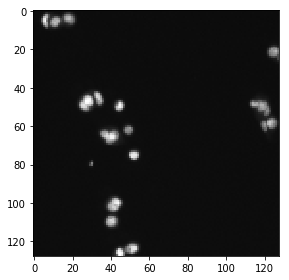

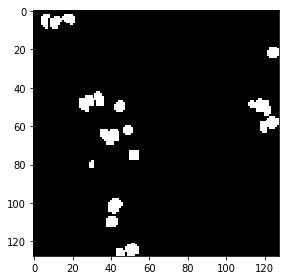

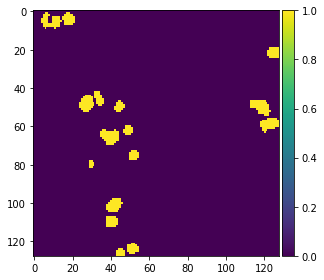

In [43]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

In [45]:
np.savetxt(DATA_PATH + 'preds_train.csv', preds_train[0], fmt='%.3f')

In [46]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [47]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [48]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub-dsbowl2018-1.csv', index=False)